# Explosivity optimization with ReLeaSE algorithm

In this experiment we will optimized parameters of pretrained generative RNN to produce molecules with values of DILI within drug-like region according to Lipinsky rule. We use policy gradient algorithm with custom reward function to bias the properties of generated molecules aka Reinforcement Learning for Structural Evolution (ReLeaSE) as was proposed in **Popova, M., Isayev, O., & Tropsha, A. (2018). *Deep reinforcement learning for de novo drug design*. Science advances, 4(7), eaap7885.** 

## Imports

In [2]:
import torch
print(torch.cuda.is_available())

False


In [3]:
%env CUDA_VISIBLE_DEVICES=1
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./release/')
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F
use_cuda = torch.cuda.is_available()
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

env: CUDA_VISIBLE_DEVICES=1


## Setting up the generator

### Loading data for the generator

In [3]:
gen_data_path = './data/Chembl_Encoded.smi'

In [4]:
#CHEMBL
tokens = ['<', '>','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
          'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
          '1','2','3','4','5','6','7','8','9','0','!','@','#','$','%','^','&','*','(',')',':',';','{','}','`']
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [4]:
gen_data_path = './data/Azidoazide_Tailored.smi'

In [5]:
#TAILORED
tokens = ['<', '>','a','b','c','d','k','m','o','f','p','q','s','u','v','y','B','E','F','G','Q','V','M','N','O','1','2','9','#','@','}','`','&','s','*']
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [3]:
gen_data_path = './data/set.smi'

In [4]:
#TAILORED
tokens = ['<','>','B', 'A','C']
gen_data = GeneratorData(training_data_path=gen_data_path, 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [6]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 0.5) & 
                                     (prediction <= 1.0))/len(prediction)
    print("Percentage of predictions within similarity region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.5)
    plt.axvline(x=1.0)
    ax.set(xlabel='Predicted Similarity', 
           title='Distribution of predicted Similarity for generated molecules')
    plt.show()

**estimate_and_update** function:

1) generates n_to_generate number of SMILES strings

2) filters invalid SMILES

3) predicts logP for valid SMILES

4) plots histogram of predicted logP

5) Returns valid SMILES and their predicted logPs

In [7]:
def estimate_and_update(generator, predictor, drug, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=150)[1:-1])

#     sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
#     unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(generated, drug, use_tqdm=True)  
    print(len(prediction))
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

## Initializing and training the generator

Initialize stack-augmented generative RNN:

In [8]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

If you want train the model from scratch, uncomment the lines below:

In [ ]:
model_path = './trainedModels/generator/TATPTailoredrnn'

In [9]:
model_path = './trainedModels/generator/AzidoazideTailored'

In [10]:
losses = my_generator.fit(gen_data,1)

Training in progress...: 100%|██████████| 1/1 [00:22<00:00, 22.51s/it]


: 

In [ ]:
plt.plot(losses)

In [ ]:
my_generator.evaluate(gen_data)

In [ ]:
my_generator.save_model(model_path)

Alternatively, you can skip the process of training and load the pretrained parameters into the model:

In [46]:
my_generator.load_model(model_path)

## Setting up the predictor

In [47]:
#tanimoto sim 
from SimilarityCalculator import SimilarityCalculator
my_predictor = SimilarityCalculator(tokens)

In [48]:
selfies = ['VV','VVMVV##VMVVMVV##VMVVMVV##&s','asdasuznx']
drug = ''

In [49]:
mol, pred, invalid = my_predictor.predict(selfies, drug)

In [50]:
pred

[0.0, 0.0625, 0.0]

Here we produce the unbiased distribution of the property:

Generating molecules...: 100%|██████████████| 1000/1000 [00:32<00:00, 30.34it/s]


1000
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


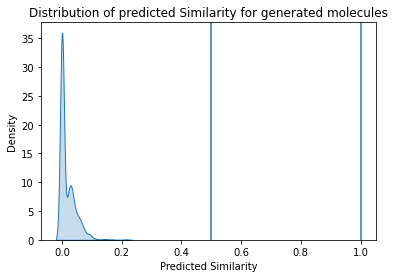

In [51]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           drug,
                                                           n_to_generate=1000)

## Biasing the distribution of the generator with reinforcement learning (policy gradient)

In [52]:
from reinforcement import Reinforcement

Making a copy of the generator that will be optimized

In [53]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [54]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 20
n_iterations = 100

In [55]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [56]:
def get_reward_logp(smiles, predictor, invalid_reward=0.0):
    drug = ''
    mol, prop, nan_smiles = predictor.predict([smiles],drug)
    if len(nan_smiles) == 1:
        return invalid_reward
#     if (prop[0] < 0.7):
    else:
        return 10*(np.tanh((3*prop[0]) - 1))+5
#     else:
#         return 1000

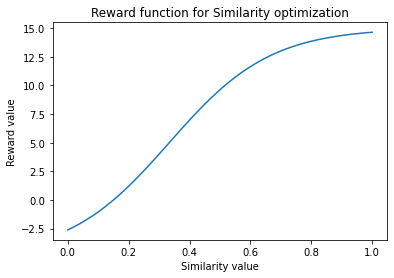

In [57]:
x = np.linspace(0, 1)
reward = lambda x: 10*(np.tanh((3*x)-1))+5 if x > -10 else 1000
plt.plot(x, [reward(i) for i in x])
plt.xlabel('Similarity value')
plt.ylabel('Reward value')
plt.title('Reward function for Similarity optimization')
plt.show()

In [58]:
RL_logp = Reinforcement(my_generator_max, my_predictor, get_reward_logp)

In [59]:
rewards = []
rl_losses = []

Policy gradient...: 100%|███████████████████████| 20/20 [00:20<00:00,  1.02s/it]


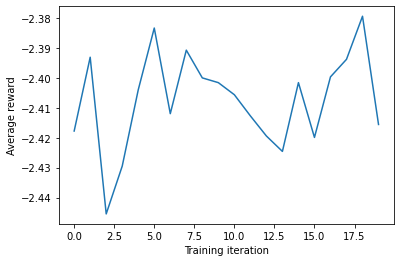

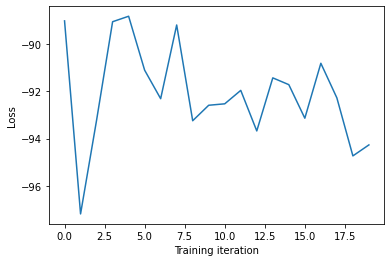

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 27.87it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


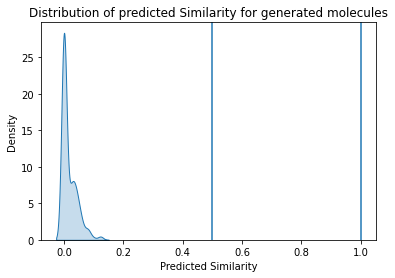

Sample trajectories:
CCCCCCCNOC=O
N[CH1-1]F
C12CCC1C(=O)NNC=NC=CC3CS2C=NC3C=O
CCNC=CC#C
[C-1]1CC2CC(C)CC(N)=C21
1 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.09s/it]


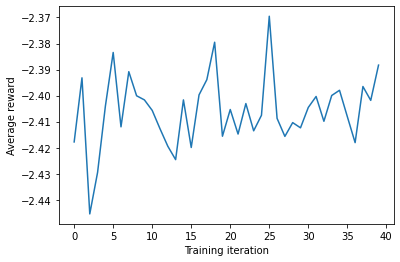

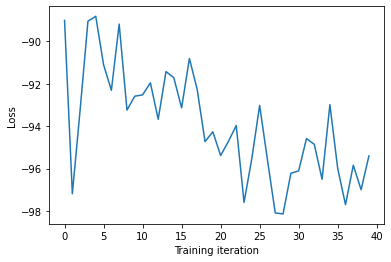

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 26.57it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


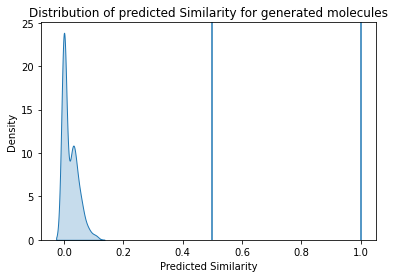

Sample trajectories:
[O+1](=C)C=CCC=COCCNCOCOC=CCC1CCC=C1CC=CC=CC(C)C=C(C)CC=C=C
C=1(C)CC=C=1
ICCCCC(O)CC=C(S1)CC(OC2C1CCC=O)CCCOCC=C2NSCC=C
N=C(C1COCC=C1C(O)CCCO)C=CC=C(O)CC(N)C
COC=CCOC
2 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.10s/it]


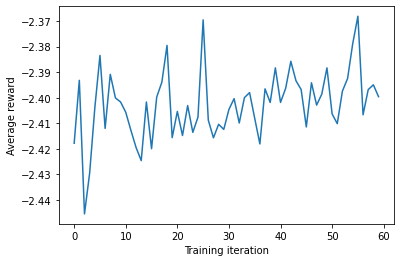

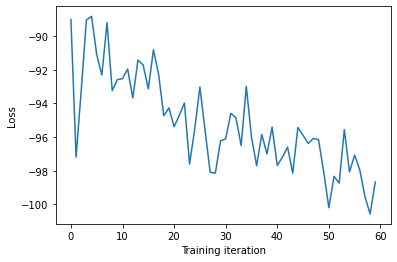

Generating molecules...: 100%|████████████████| 200/200 [00:05<00:00, 36.26it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


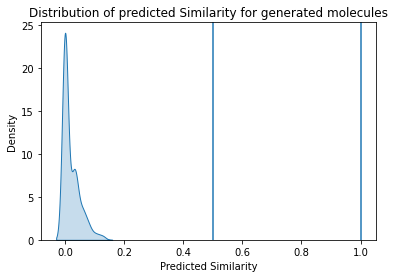

Sample trajectories:
C=CC#C
CCC1=CC(NN)C2C=CC=C2C1=CCC=C
C#N
CC1CC=CC=C1O
CCC=NC(C)=CCC1=CC2=C1NC=CC=C2
3 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:20<00:00,  1.00s/it]


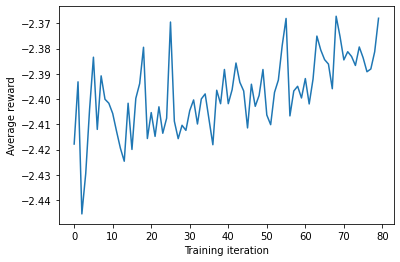

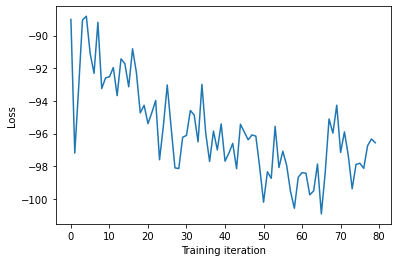

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 31.28it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


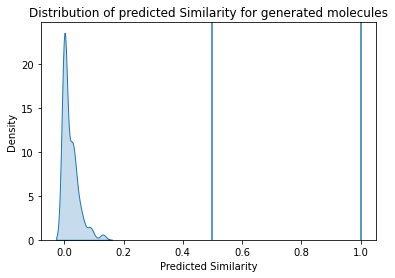

Sample trajectories:
[P+1]#C
[B-1]=1C(C=1)C(C)Cl
ICSCS
C(=C)CC=CC=C(COC=CC=CCl)N=C=[O+1][O+1]CC=C
C1(=C)OC=C1CONCC=CC=C
4 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:20<00:00,  1.02s/it]


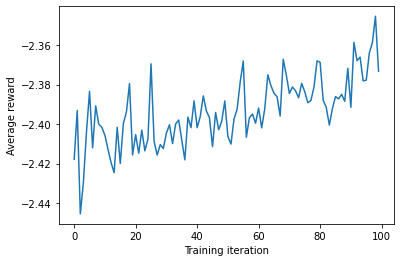

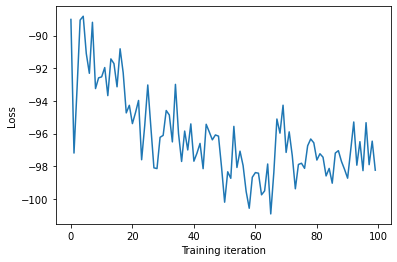

Generating molecules...: 100%|████████████████| 200/200 [00:05<00:00, 33.34it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


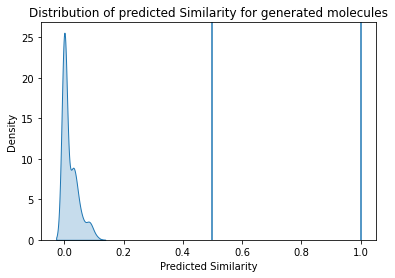

Sample trajectories:
N
O=SF
CCOCCC(=O)CC1C=C(C(C)=C)P1
C1(CCC123)C2=C3CC=C=C
C(=O)C=CC#C
5 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:18<00:00,  1.11it/s]


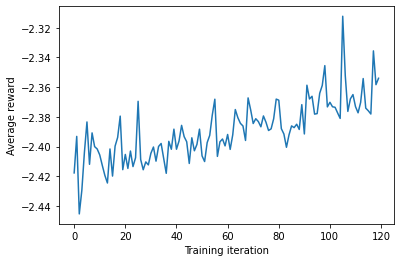

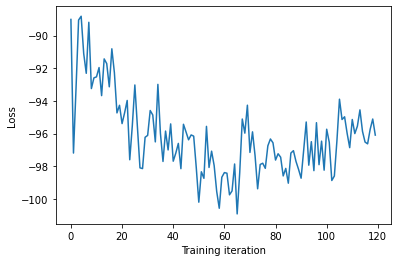

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 30.78it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


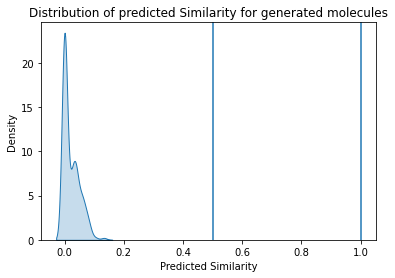

Sample trajectories:
C=[OH1+1]
C1C(=O)C=C1C=O
C(F)C=CC=CC=CC\OC
[PH0]C#N
C12CCNCN1C=CC3=CC=C23
6 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:18<00:00,  1.09it/s]


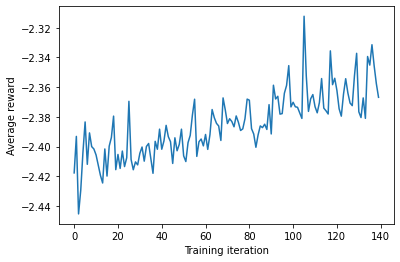

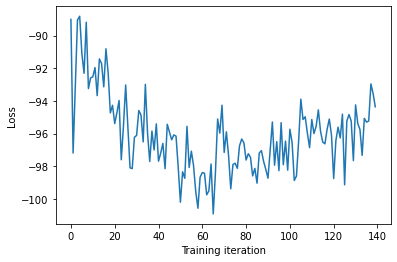

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 28.78it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


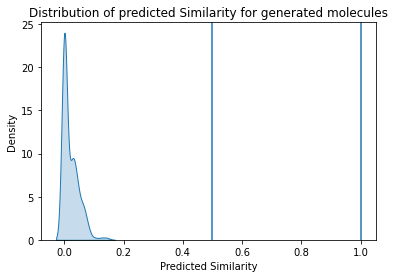

Sample trajectories:
CCCCCl
CC(C)CCOCNC(C1)CCC(C)C1C=O
C#CNC1=CC=CC=C1
CC12CC=C=NC=C1C=C2
IC=CC1=CCCC(C)C=C1
7 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.14s/it]


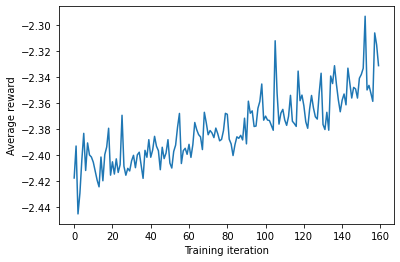

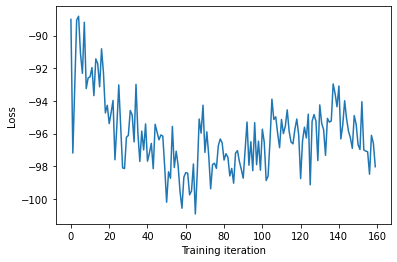

Generating molecules...: 100%|████████████████| 200/200 [00:08<00:00, 24.95it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


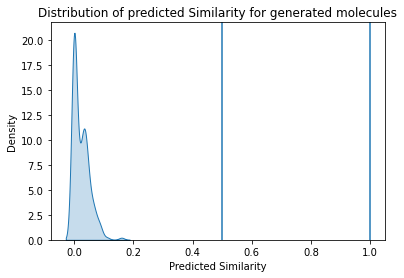

Sample trajectories:
C1=[I+2]C1C=O
COC=O
[NH1-1][CH2]Br
C#COC(O)N1C=CC=C(CCl)C(C)C#C1
[C-1]1C=C(C2NCC3CC)N3C=C21
8 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.11s/it]


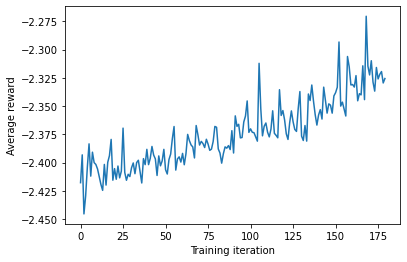

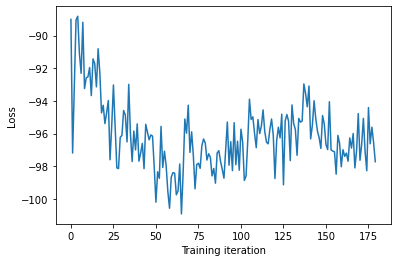

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 28.26it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


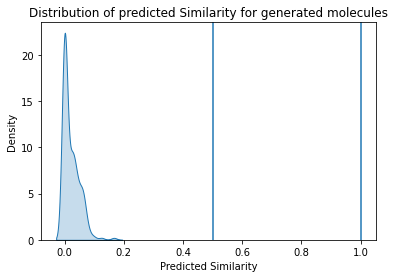

Sample trajectories:
CCC=CC1=COC=CC#C1
C1CCCCCC(C)C1=C
CCCNNCOCCl
C12CCCC13C(C)=C2CC3C=O
C12[I+1]C=CC13CN3C4(C)C=CC=C24
9 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.09s/it]


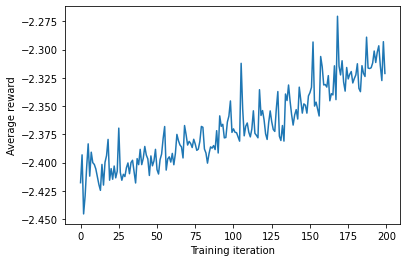

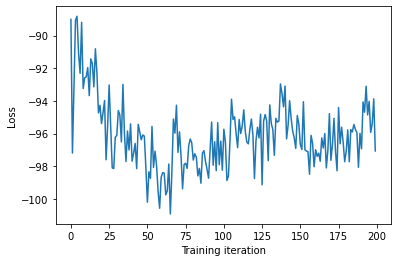

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 29.31it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


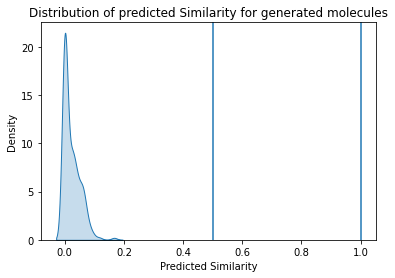

Sample trajectories:
CCOCC(C)CNC=CCOC1=CC=CNOC=CC=CC=C1C=C2CC2CC
OC#CC=CCOC=CC=CC=CC#C

C1C=C1C=CI
CC=[OH1+1]
10 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:19<00:00,  1.01it/s]


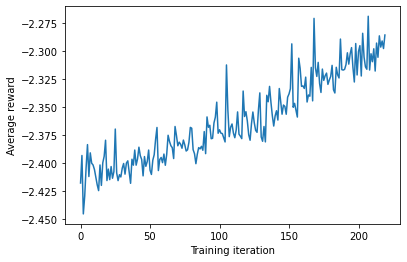

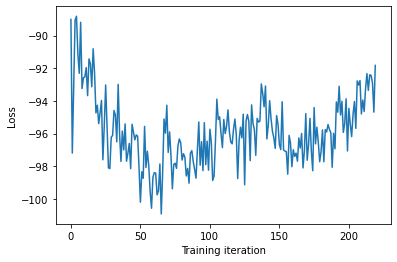

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 26.97it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


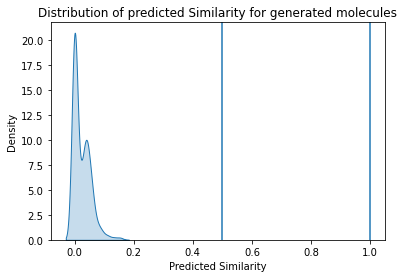

Sample trajectories:
C1S2=CCC3C1S3N2
N12CCCNCCC=CC3C=C1C=C23
C(C)#CC#C
[O+1]=O
C=1C=CC=C=1
11 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.07s/it]


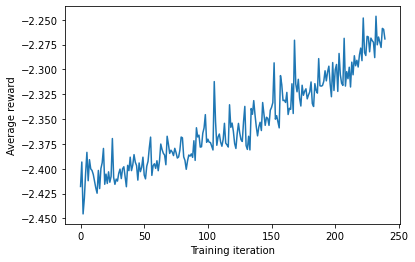

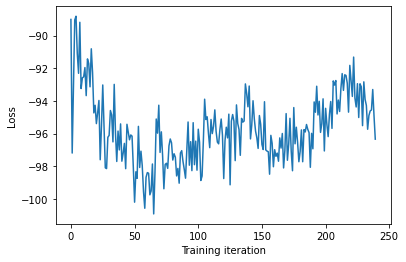

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 30.86it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


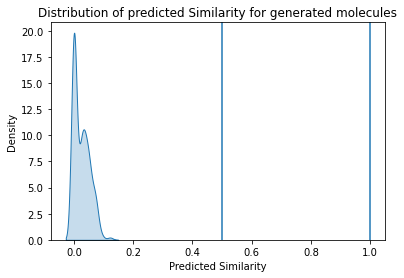

Sample trajectories:
C1=C(O1)OON=N
C=C=C
C
IC=O
C1=[NH1+1]C1N=N
12 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:18<00:00,  1.07it/s]


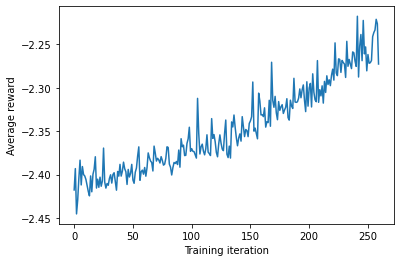

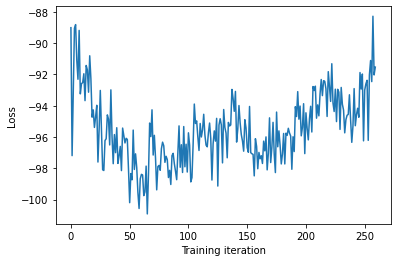

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 31.00it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


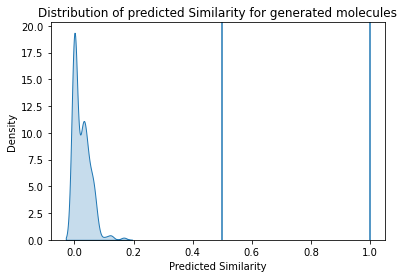

Sample trajectories:
CCOC1OOSC=CC2=C1C3C=CC=C2N3
N=1C=CC=C=1
C123C(=CC)CC=C1N2CC=CC=C4C=C4C=C3CC
C12C(C)=C1C=C2
C123CCC4C1C=C2CC=C34
13 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:18<00:00,  1.10it/s]


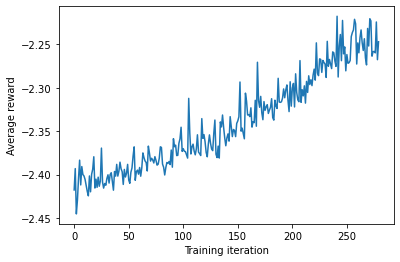

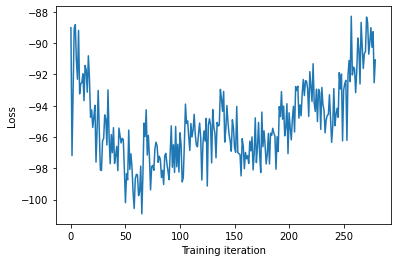

Generating molecules...: 100%|████████████████| 200/200 [00:05<00:00, 33.65it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


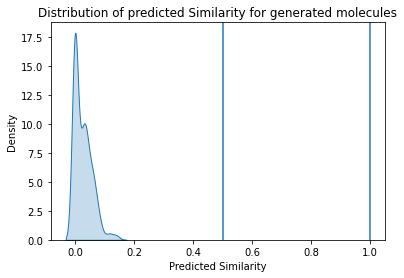

Sample trajectories:
C12=CC=CC(C=CC1)C(C)C=CCC2C=CCO
C1OC1C=CC=C
C=C=[S+1](C)C=CC=C1CC=CC=CC#CC=NC=C1C=C=CC=C
C=CC1=CN1CNCC(=C)Cl
C
14 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:19<00:00,  1.04it/s]


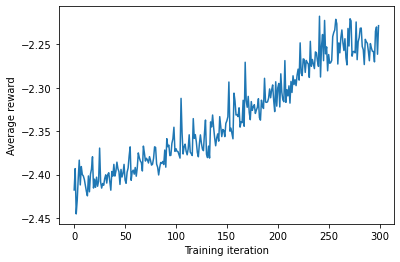

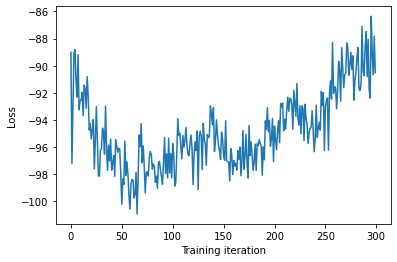

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 25.46it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


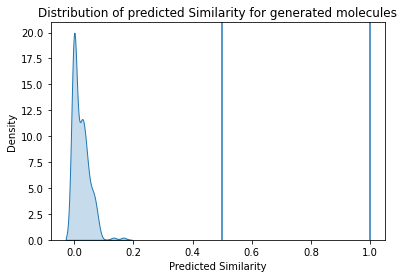

Sample trajectories:
CNCCN=C=C
C1CCC=CC=C2C1(C3)C(C)C=CC=C23
CNC1C=C1
C1=C=[N+1]C#C1
S=O
15 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:24<00:00,  1.22s/it]


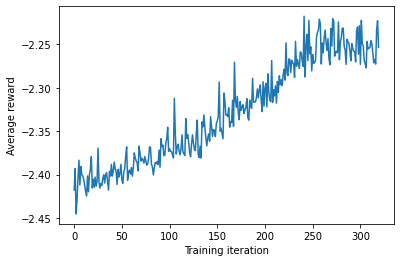

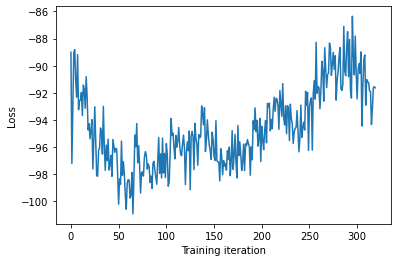

Generating molecules...: 100%|████████████████| 200/200 [00:08<00:00, 24.91it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


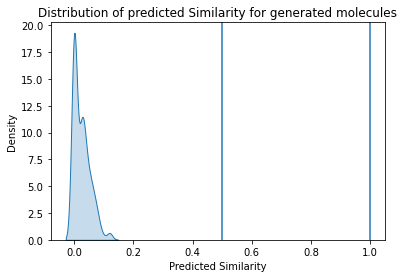

Sample trajectories:
CCCCC=CCC=CCC1(C2)C2(CCCOC3COC31C4CN)C=C=C4C=O
SCNF
C#C
C=CC=CCCCCCN1C(=O)NNC=C1C=CN=CCC
C1C=N1
16 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.11s/it]


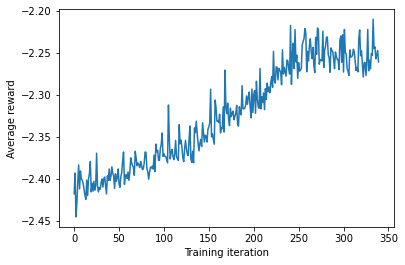

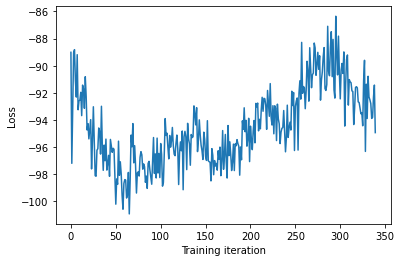

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 27.58it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


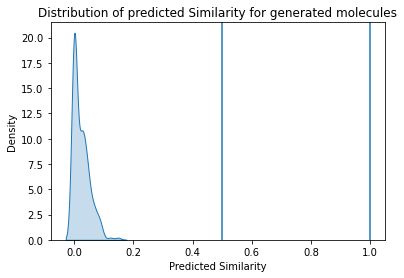

Sample trajectories:
N
CC=CC(=O)[N+1]
C1NCCSC=CC=CCC1C=N
S=1C=C=1
C1=CC2=CC=C1PS2=C=COC=O
17 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.06s/it]


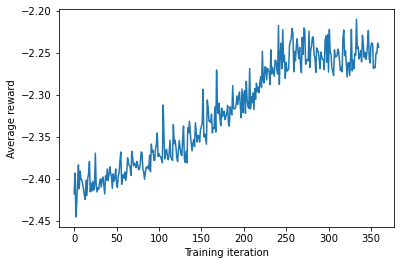

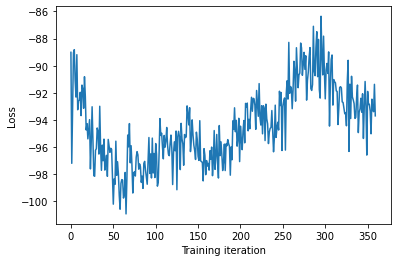

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 31.79it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


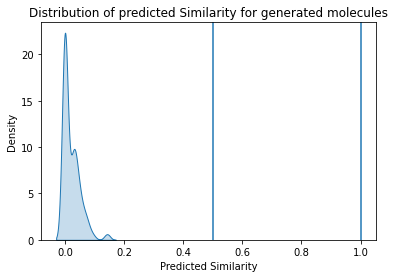

Sample trajectories:
C=O
C1=2C=C3C=C1S3=2=N[CH1][NH3+1]
C=O
C=CC=CC=O
C=O
18 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.08s/it]


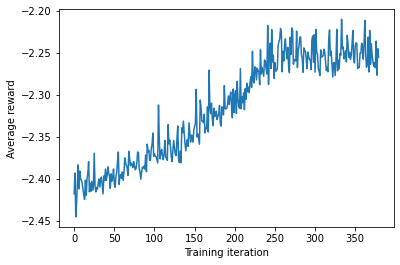

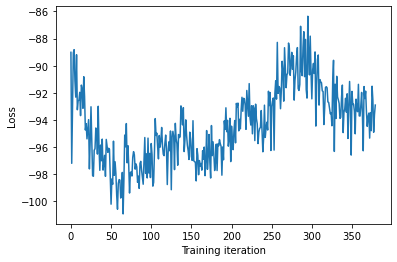

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 29.64it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


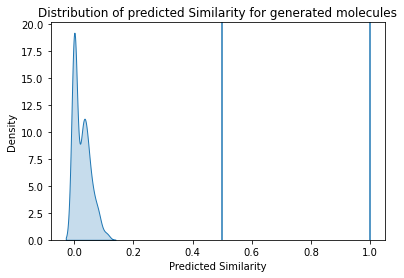

Sample trajectories:
C1[S-1]CNC=CC=C1C=CC2CCCN2
[N+1]C=O
C12CCC=CC=C1CC=C2N
C1(C)C(C)COC2C=NC1NC2(C)C=O
C1COC=C1S
19 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.08s/it]


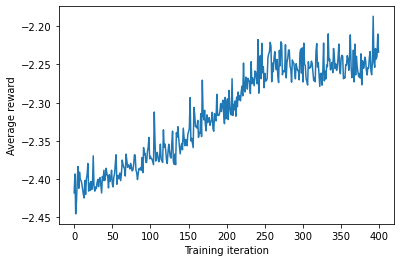

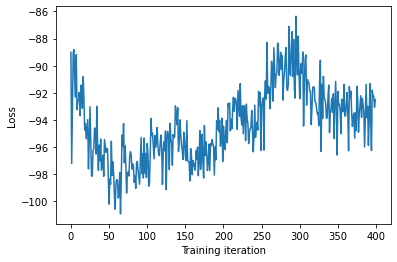

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 27.31it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


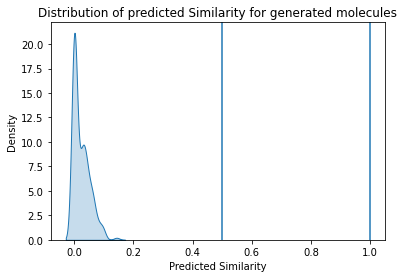

Sample trajectories:
FF
C1CCC=N1
C=CN
OC=CC=C(C1COC=O)CC=CC=C1
[NH1-1]C=[N-1]
20 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:20<00:00,  1.02s/it]


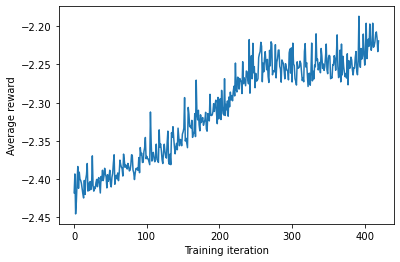

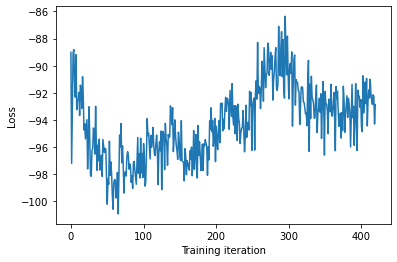

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 28.30it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


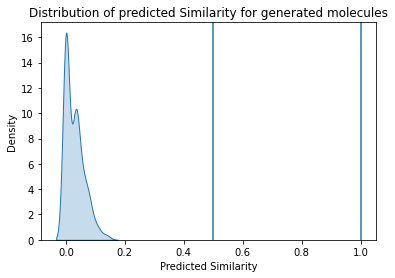

Sample trajectories:
O1C=CC=CC=CC1C(O2)C3=C=C32
[S+1]12CC1C3CCC=C3C=CC=C2NCOC=CC=CC=C
NN
C=O
OC
21 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.07s/it]


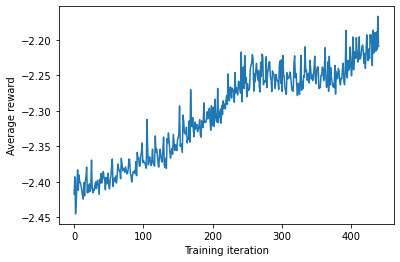

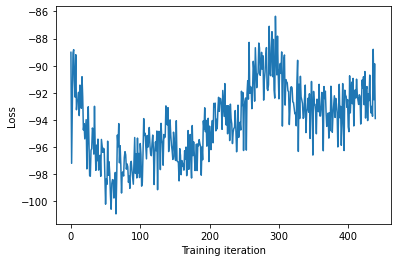

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 27.04it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


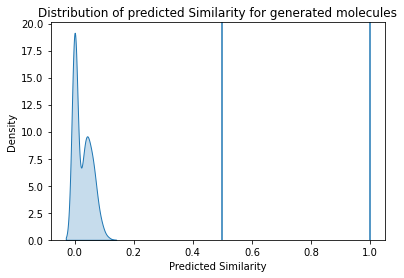

Sample trajectories:
C1CCCCCOCC1C2=CC=C=C2[NH3+1]
C
CC=C
C1(O)C2=C(N)C=CC2C=C=COO1
NC#N
22 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:20<00:00,  1.04s/it]


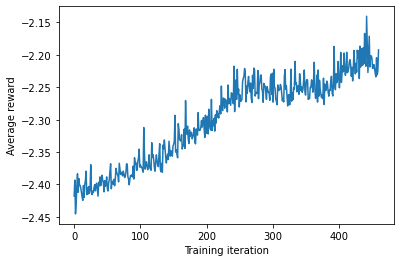

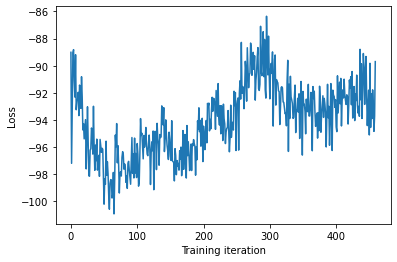

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 27.40it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


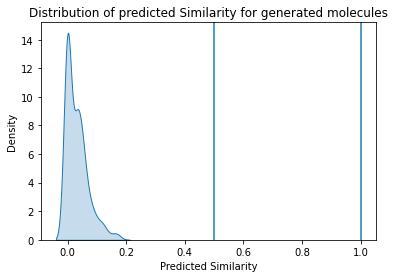

Sample trajectories:
C1CON2CC=CC=C12
C1C/SC=CC=CC#C1
C1C2CC=CC=C21
C1CC(C)C1C
C1CCCCCCOC=C(C)CC1C=CC=CC=O
23 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.14s/it]


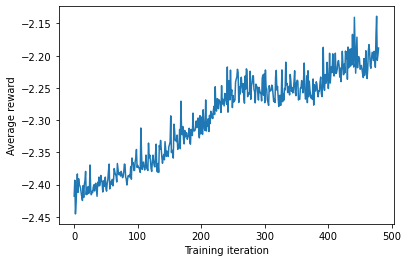

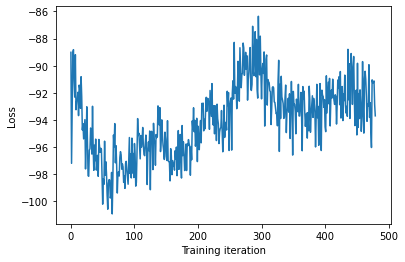

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 26.05it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


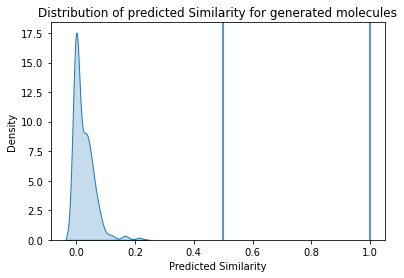

Sample trajectories:
CCl
C1=NC(C)CC=C1NCC(C)CC2CC2
[CH1]1N=COC=C1SCC=C
CCCCOCC=C1C=C1C=C2C(C=CC3=C2C34)/S4C
C=1(N)C=NC(C=O)C=C2C=C2CCCC=1
24 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:23<00:00,  1.17s/it]


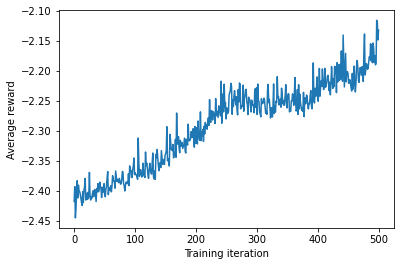

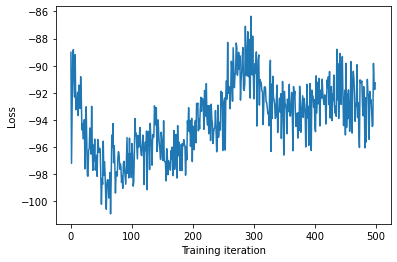

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 29.02it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


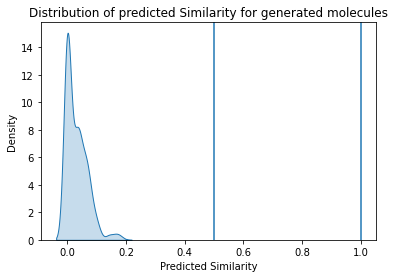

Sample trajectories:
[N-1]1OC1
CN=O
O1COCCC=CC(=O)NOC=C1CNC=O
C1NCC2OC[OH0]C=C2C1
C1COC1C2C=N2
25 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.07s/it]


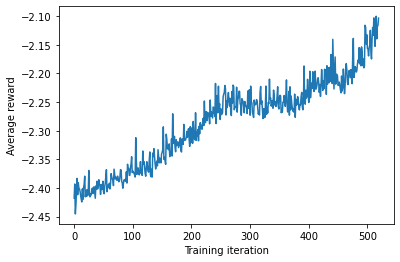

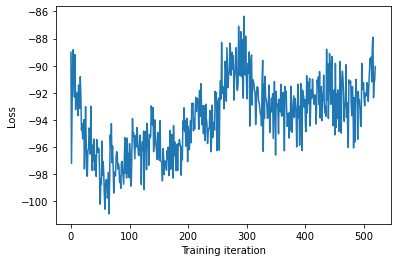

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 28.29it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


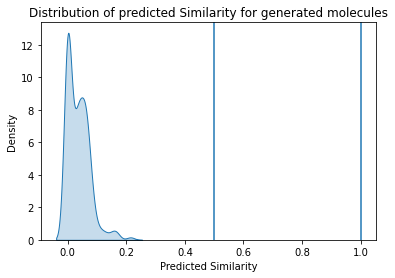

Sample trajectories:

C1CCC#C1
C12CC=CC=C1C[S-1](=O)CC2CC(C)C=O
C1#CO1
CCCC=S1CCOCO1
26 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.14s/it]


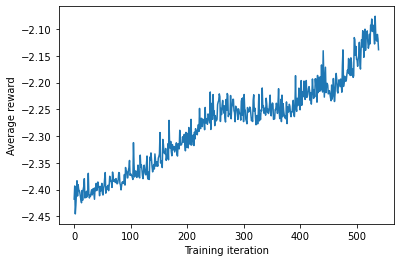

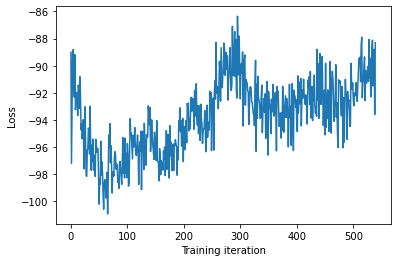

Generating molecules...: 100%|████████████████| 200/200 [00:08<00:00, 22.69it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


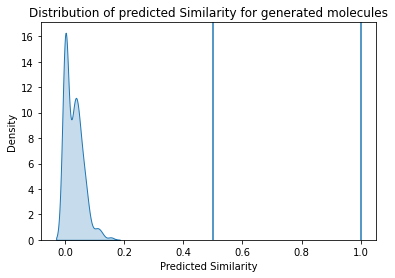

Sample trajectories:
C123COCCNCNC1CC2(C=O)N3CCC(C=O)(C=O)C=O
C12=POC=CC(=O)CCC=C1C#C2
C=CC=O
C1C2C3OC13C=C=C2
C123CCCC=CC1C3C2
27 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:24<00:00,  1.25s/it]


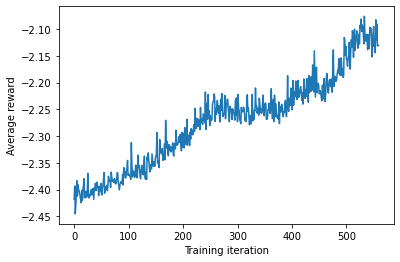

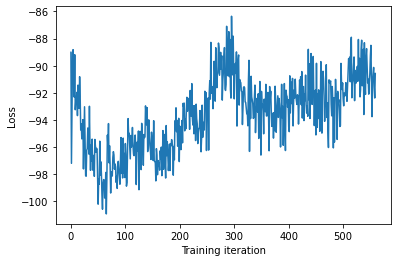

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 25.28it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


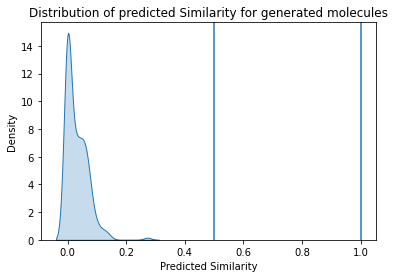

Sample trajectories:
[N+1]O[NH3+1]
C=C
C1#CC1
[I+2]=[OH1+1]
[I+1]1[CH0]C[NH1]C=C=C1C
28 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:24<00:00,  1.22s/it]


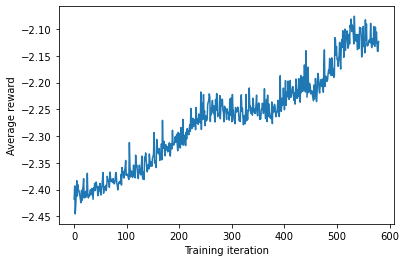

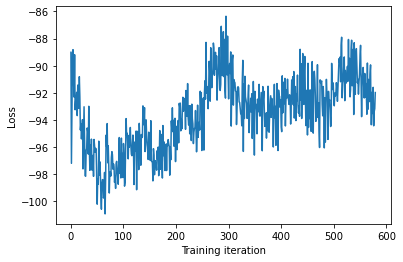

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 27.75it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


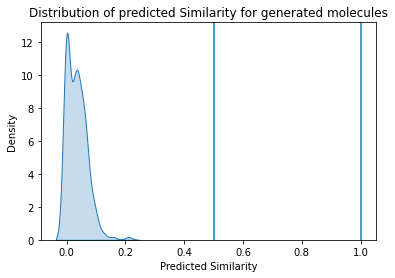

Sample trajectories:
CCOC(C)N=CCOCCl
C1C=CC=CC1O
C12C=CC=C1N=C(C)CC2(O3)NC=CC=C3OCC=O
OF
C
29 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.05s/it]


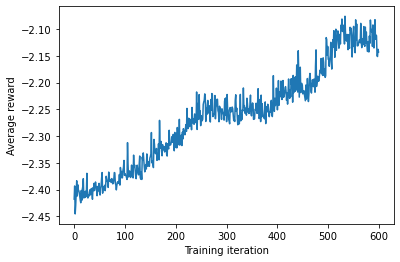

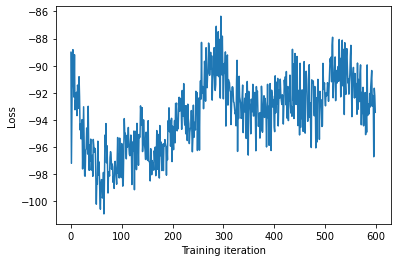

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 26.72it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


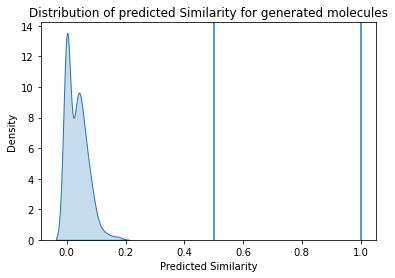

Sample trajectories:
C=O
C1=CC2C=C3C=C3N12
C=C1C=N1
C12CC=C1C2C
P12=3CC14NC=C2C=C4OC=3[C-1]
30 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.11s/it]


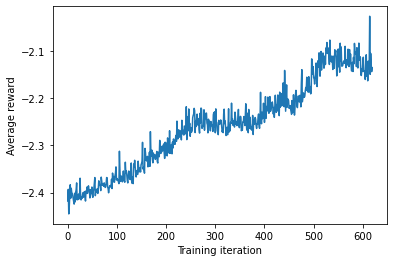

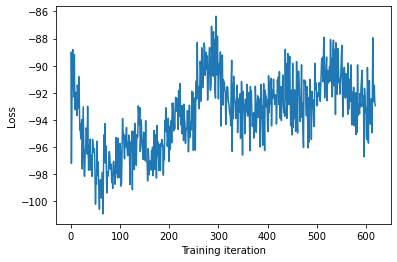

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 29.40it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


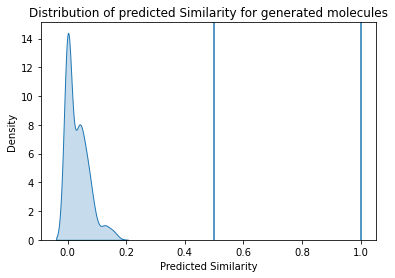

Sample trajectories:
CCC1(C)C=CC1=CCl
[N+1]=1C=C(N)C(CCCC)C=1C
C12CCN(C)C1C=C2
CF
[N+1]
31 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.13s/it]


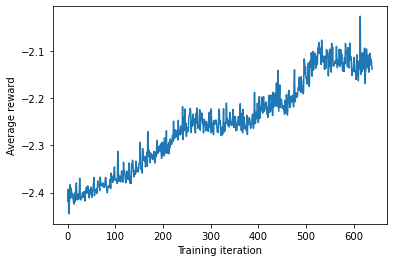

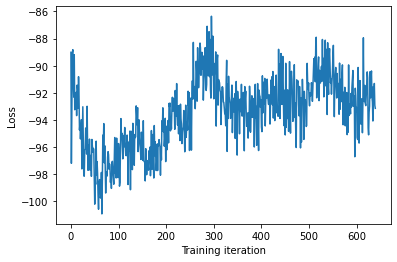

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 25.76it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


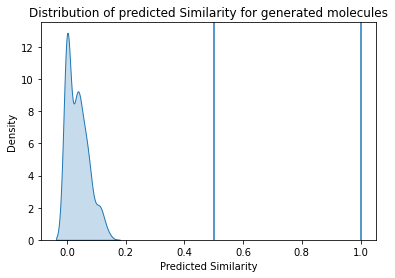

Sample trajectories:
CC=NC=C
O1C=CCOC1C#COC2C(N)C=CC2C
S12CS1(O)C3CC=C3C=C2O
C=1CCCOC=1
C1NC=C1C=O
32 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:20<00:00,  1.04s/it]


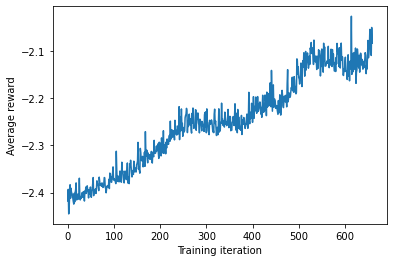

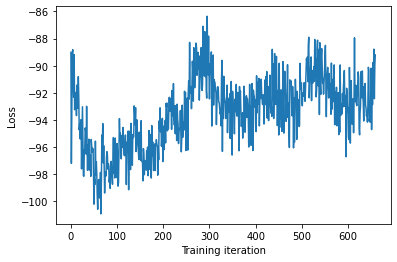

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 27.46it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


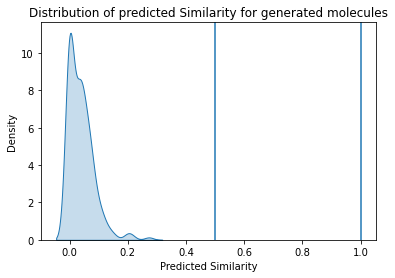

Sample trajectories:
CCCCOCBr
CCCOC=O
C=O
C123C(C)OCC1C2=C(C)CC4C(=P(Br)=O)C=C4C=C3C
C12CC=C1CCCCO2
33 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.07s/it]


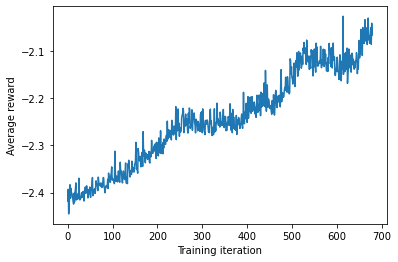

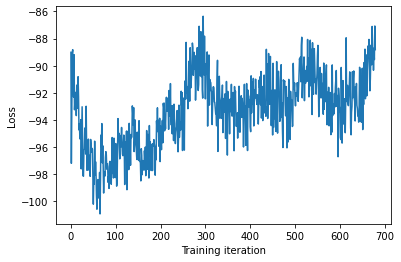

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 26.56it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


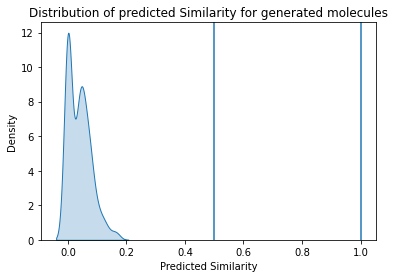

Sample trajectories:
[NH3+1]COCOCC#CCOC=O
C1=CC1[O-1]
O1CCOC1O
C1OC1
C1(C(C)=C12)C2
34 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:20<00:00,  1.05s/it]


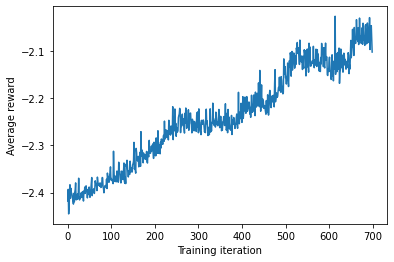

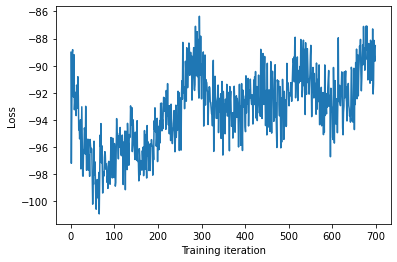

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 28.17it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


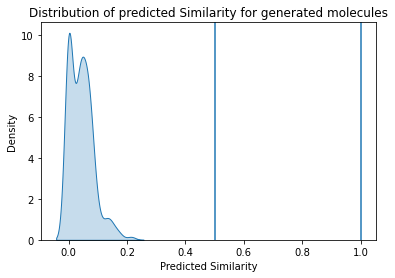

Sample trajectories:
C1NC2NC3S=4CC31C=42
C1CC2=C1C#CC=N2
[S+1]1([CH1]=[N+1]1)[NH1]OCOCC2CNC#CC2=O
C1CC1
C1N2CCCC3C2C(C)CC=C1C=CCO3
35 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.11s/it]


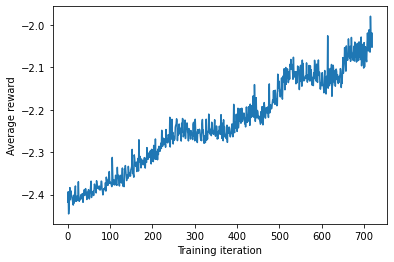

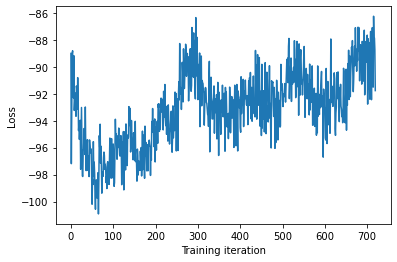

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 27.48it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


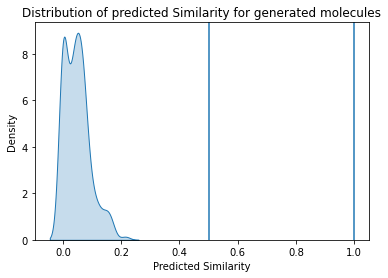

Sample trajectories:
C12N=C1CC2CC3=CC3
C1OCOC=C1
C=O
CCC=C1CC[B-1]C(C1)NC=C2C=C=C2
C123C(=C)C=C1C=CC=C2N3NOCC4=CC=C=C4
36 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:20<00:00,  1.00s/it]


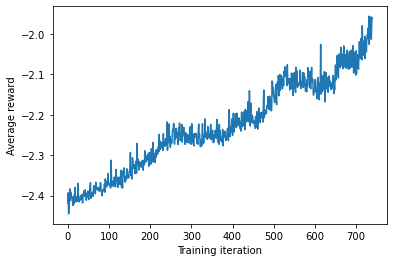

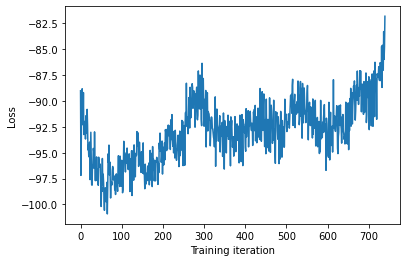

Generating molecules...: 100%|████████████████| 200/200 [00:05<00:00, 35.06it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


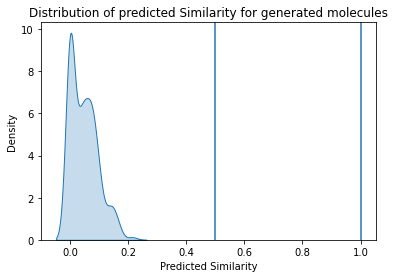

Sample trajectories:
C1C=C1
CC
C1C#C1
C=C1C=C1[PH0][NH1]CN(CC2C)C3CC=C32
C12C3COC=C3N1OCN2
37 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:18<00:00,  1.10it/s]


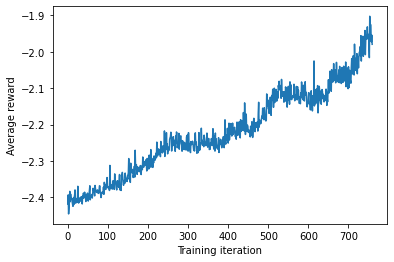

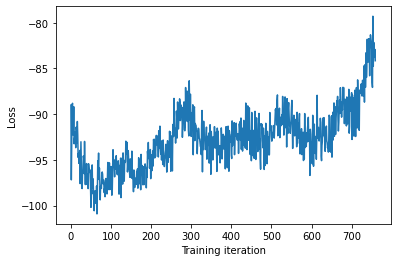

Generating molecules...: 100%|████████████████| 200/200 [00:05<00:00, 36.55it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


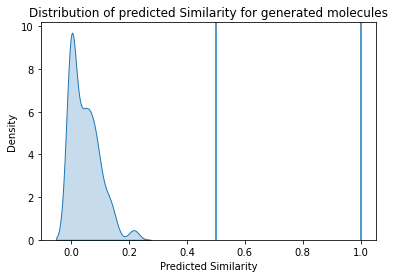

Sample trajectories:
[P+1]123NC1(O)CCC43C2C=CC=C4
CCCCCC(C)N1C2CN2C=C1
O[O-1]
C1=CC2C=CC=C12
C=O
38 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:19<00:00,  1.03it/s]


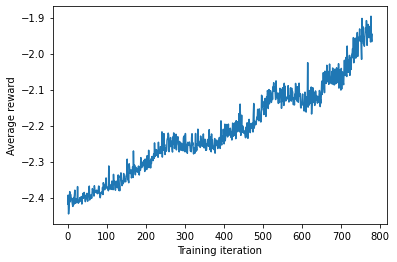

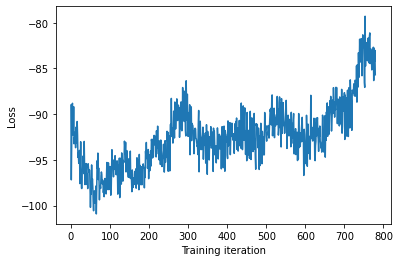

Generating molecules...: 100%|████████████████| 200/200 [00:05<00:00, 36.01it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


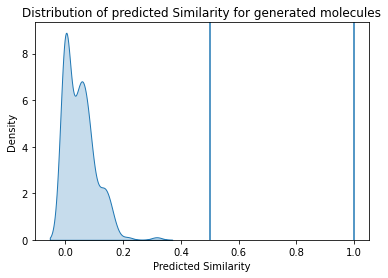

Sample trajectories:
NCCl
CN=[N-1]
C1COCCC2CN=C12
P=S#[O+1]
C(C)#C[NH1]C
39 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:17<00:00,  1.14it/s]


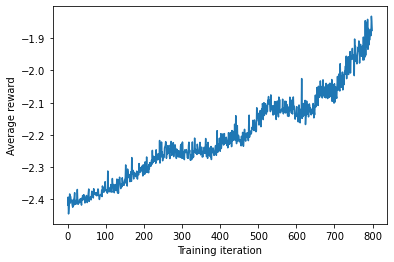

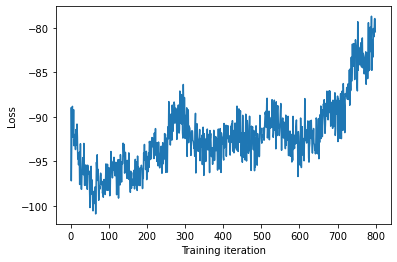

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 28.67it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


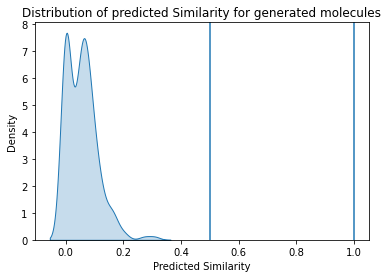

Sample trajectories:
C1C=NC=C1
[CH1]
C12OCC1(O)NC=N2
IC=C
C=C
40 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:18<00:00,  1.08it/s]


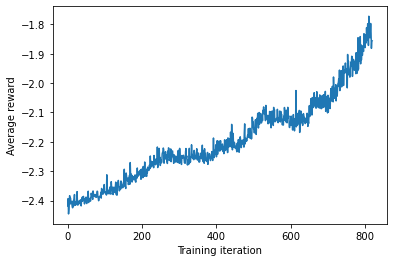

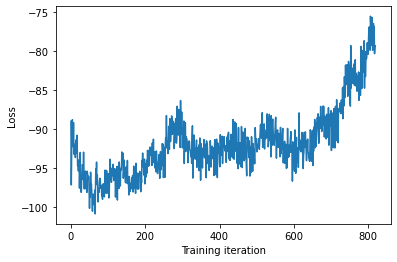

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 28.69it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


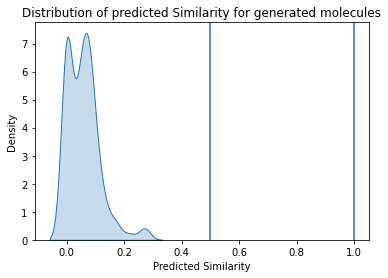

Sample trajectories:
CCBr
CCC=N
C1OCC1OC=O
C12C3OCC1=[I+2]C3CO2
NC=O
41 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.07s/it]


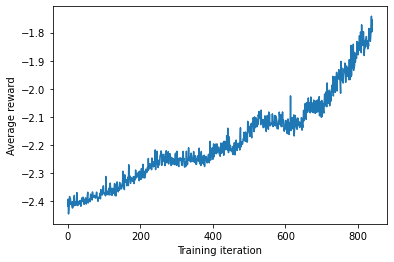

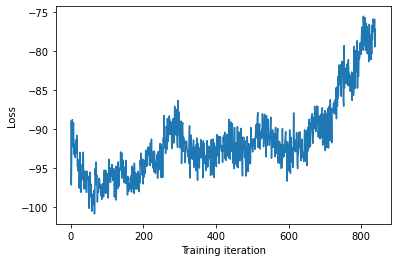

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 27.27it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


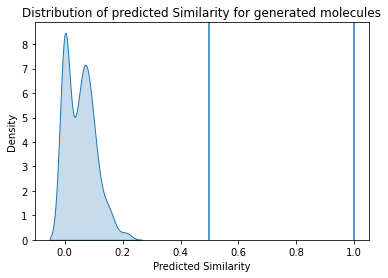

Sample trajectories:
C1=C(N)OC1
CC=[NH2+1]
C123C=[N+1]C4(O5)C51C2C=C43
CCNCCl
C=1NC2=CCC=1ON2CC3CN3N[N+1]PC
42 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:23<00:00,  1.16s/it]


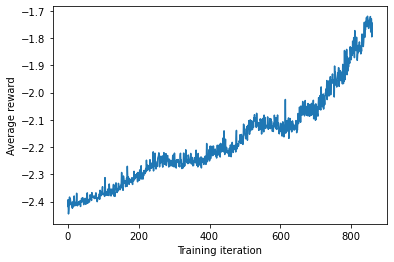

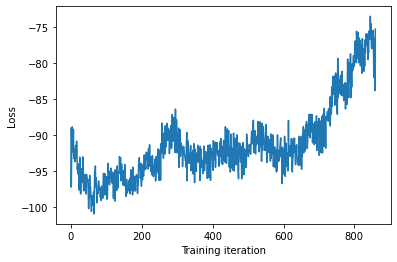

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 28.55it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


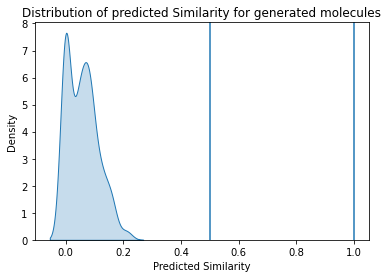

Sample trajectories:
C1C(C)COCC2OC=CNS2ONP[NH1]1
B1C2COCOC21NC=O
CCF
O1OC#C1

43 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.11s/it]


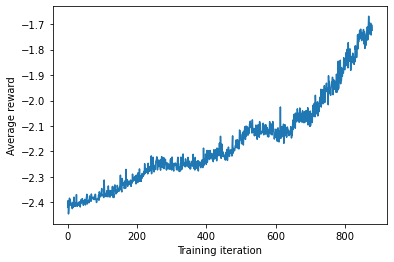

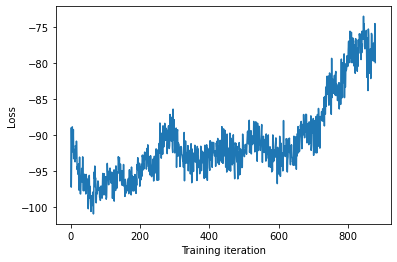

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 31.94it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


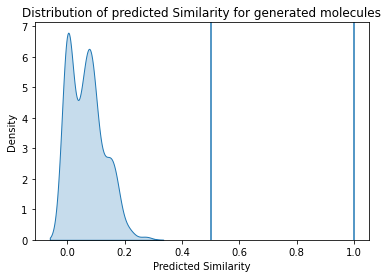

Sample trajectories:
C12C=NC1CO2
[P+1]C=C1CO1
C1CCOCN=N1
C12CC=C1O2
CCO[B-1]COC=O
44 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:20<00:00,  1.04s/it]


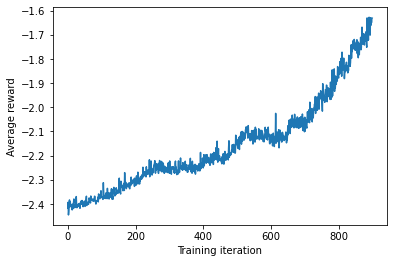

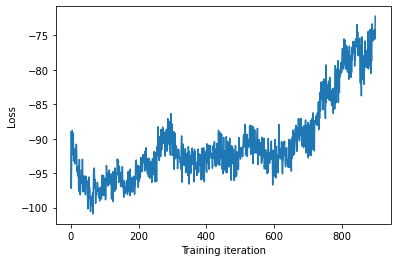

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 29.15it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


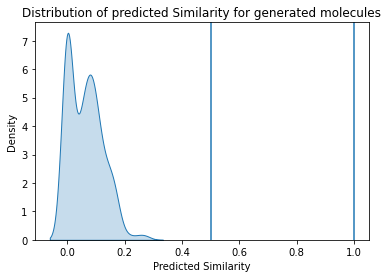

Sample trajectories:
C12[P+1]=CC1OCOOOCCN2COCOC
C=1OCCC=C=1
C1OCO1
C1SCOC1
C[C-1]=O
45 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.08s/it]


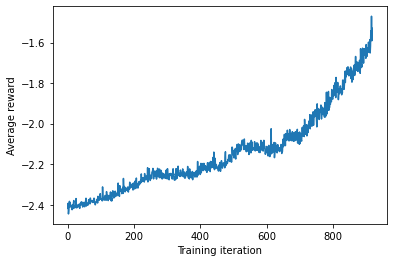

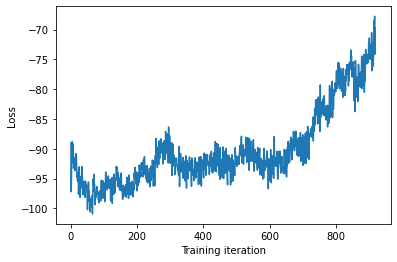

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 29.77it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


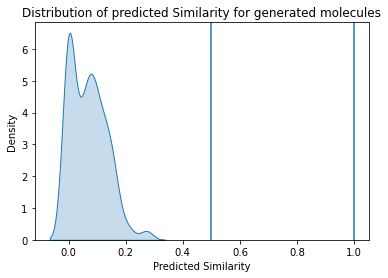

Sample trajectories:
N=1C=C=1
C=1=CC=1CNCN2C(O)ON2
C1C2CCON=C21
C1COC=C1NO
CCCC=NN1NC1Cl
46 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.12s/it]


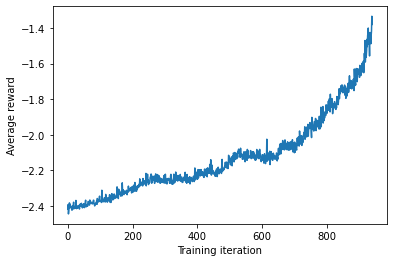

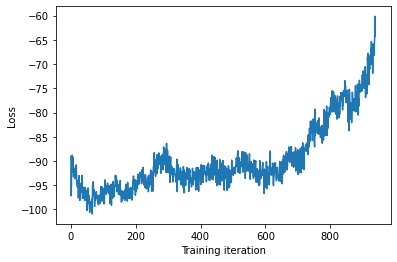

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 27.26it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


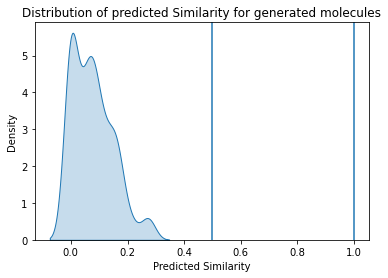

Sample trajectories:
N=1C2(N=1)CCON2
C=1CCCOONOOC=1N
C1NOC#CNCO1
C123CC2(CO1)SC=C=S3
C1#CC1COCBr
47 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.08s/it]


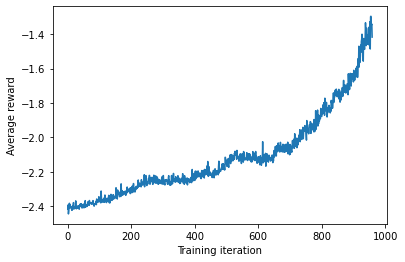

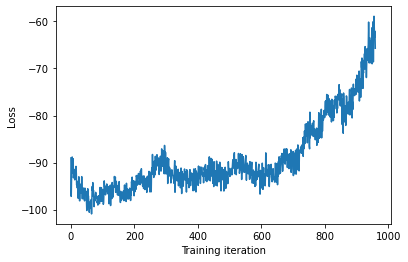

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 28.70it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


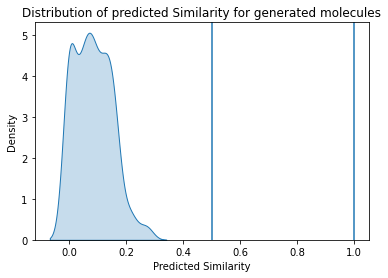

Sample trajectories:
F\OCl
CCC1OO1
CC=O
C1[NH1]O1
C1OCCO1
48 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:19<00:00,  1.01it/s]


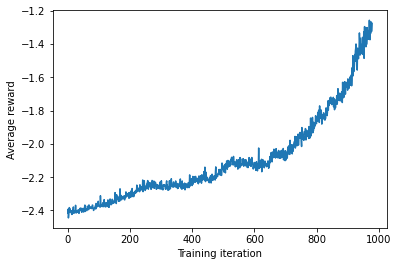

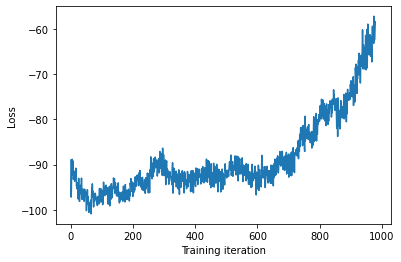

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 28.88it/s]
[12:29:20] Explicit valence for atom # 0 I, 6, is greater than permitted


199
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 0.995


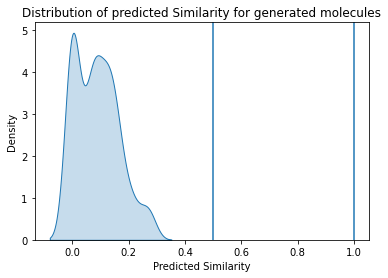

Sample trajectories:
C=C(N)[O-1]
C1OCO1
C=1ONC=C=1
C1[CH0]COON1CC2CO2
C12OC=C1[P+1]O2
49 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:18<00:00,  1.08it/s]


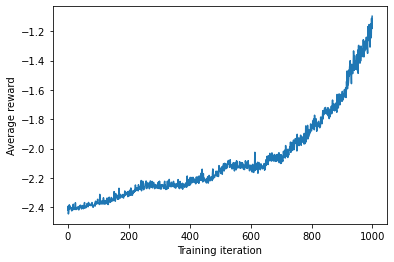

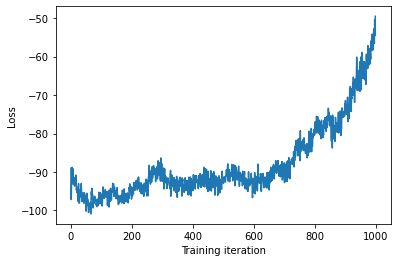

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 27.30it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


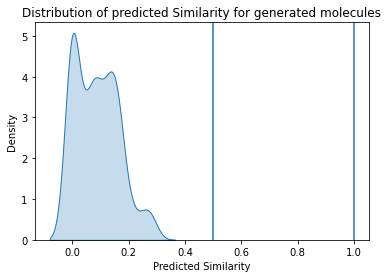

Sample trajectories:
C#1NC#1
CNCCC
C1OO[CH1]OO1
C1NCO1
C=1CCOCN=C=1
50 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:21<00:00,  1.05s/it]


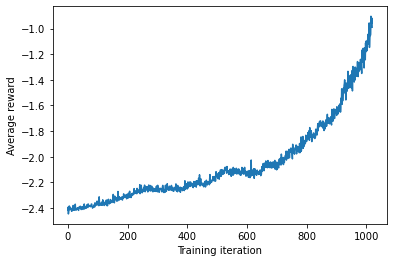

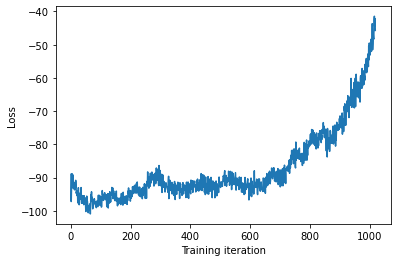

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 30.54it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


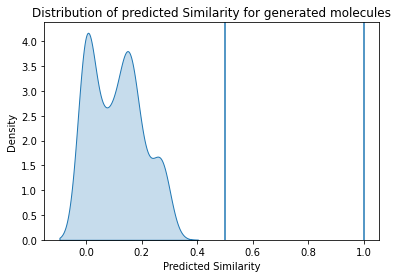

Sample trajectories:
C1CO1
C=O
COO
[CH1]12CCC=S1N2OC=O
C1COOOO1
51 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:19<00:00,  1.00it/s]


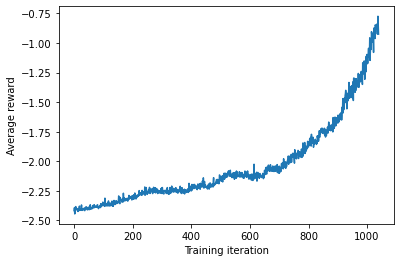

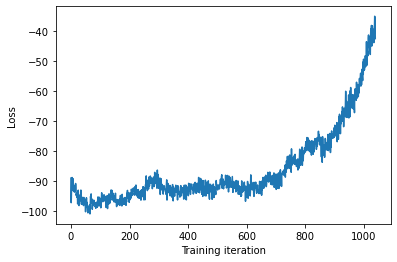

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 29.21it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


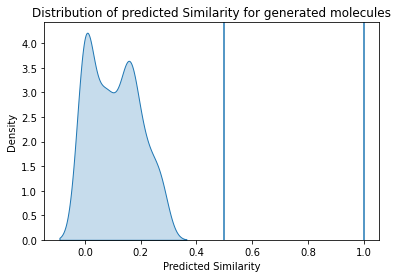

Sample trajectories:
C1CO1
C1O[NH1+1]NOO1
[CH1-1]I
C1CCOO1
C1CO1
52 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:20<00:00,  1.05s/it]


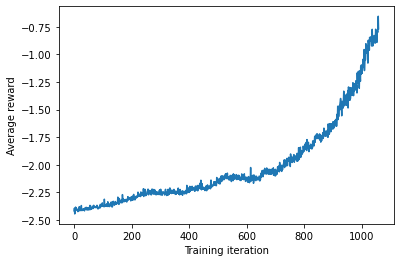

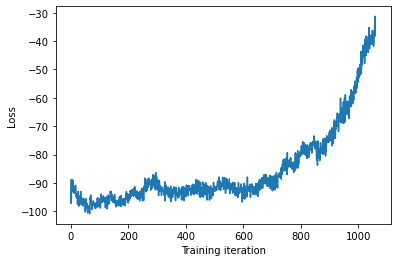

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 32.92it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


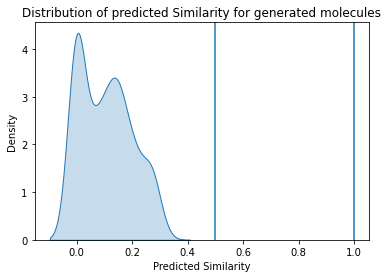

Sample trajectories:
C1OO1
C1ON1N=O
C1OO1
[I+2]OCC1OO1
S1CC(CO1)=O
53 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:20<00:00,  1.03s/it]


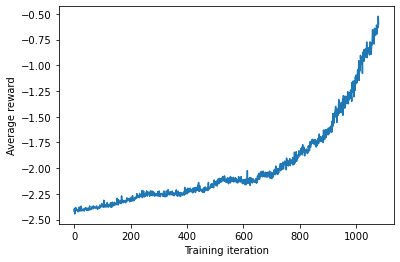

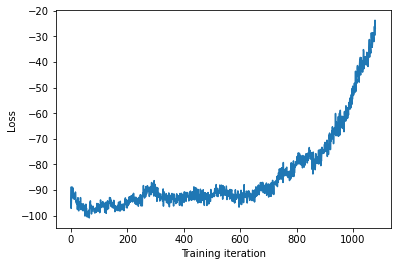

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 30.67it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


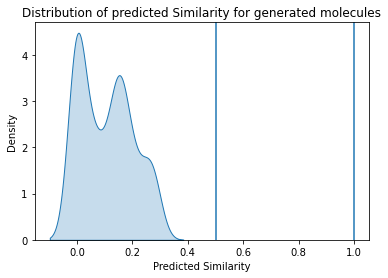

Sample trajectories:
C1OO1
C1ONCOCO1
C1OCC=CO1
[NH1+1]O
C(N1COO1)O
54 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:19<00:00,  1.00it/s]


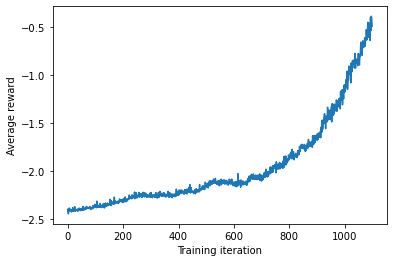

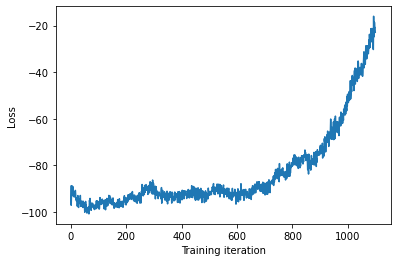

Generating molecules...: 100%|████████████████| 200/200 [00:06<00:00, 30.80it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


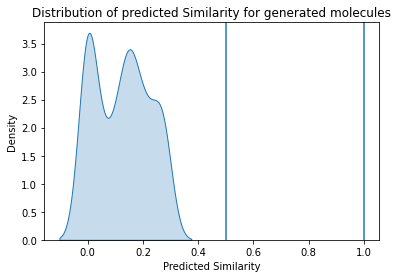

Sample trajectories:
C1CO1
C1CCOO1
C1OO1
C1C=NO1
CCOOO
55 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.11s/it]


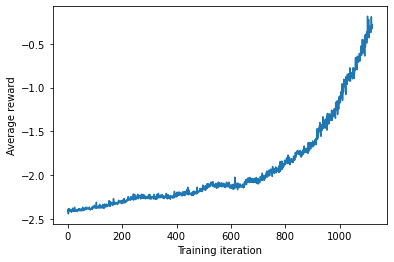

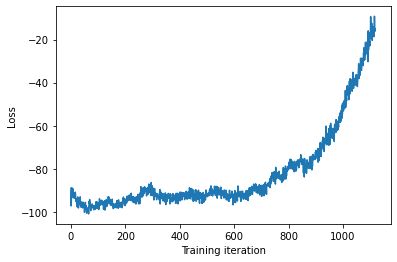

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 28.09it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


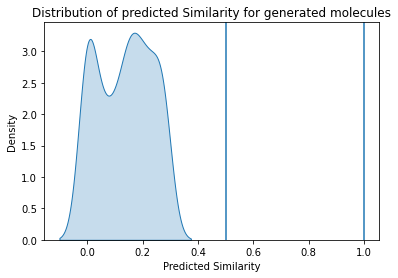

Sample trajectories:
C1OCO1
C=O
C1COOO1
C1COOO1
N12C=C1O2
56 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:23<00:00,  1.19s/it]


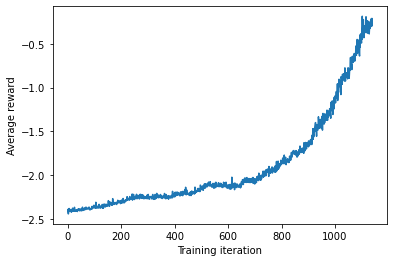

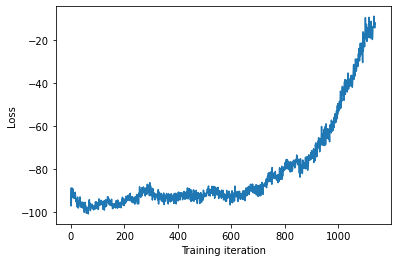

Generating molecules...: 100%|████████████████| 200/200 [00:09<00:00, 21.59it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


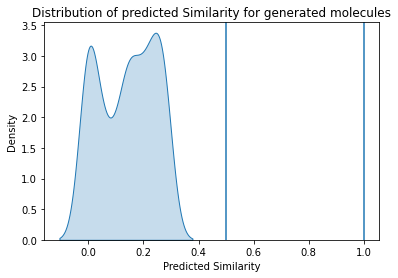

Sample trajectories:
C1OCOO1
O1C=CC=N1
C1OCO1
C1COCOO1
C1(O)COO1
57 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:24<00:00,  1.21s/it]


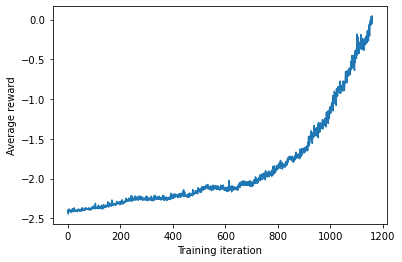

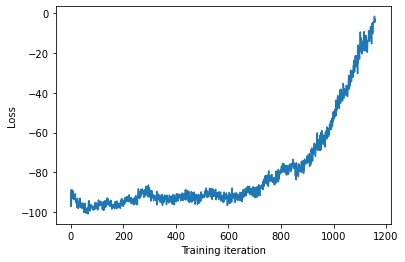

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 25.68it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


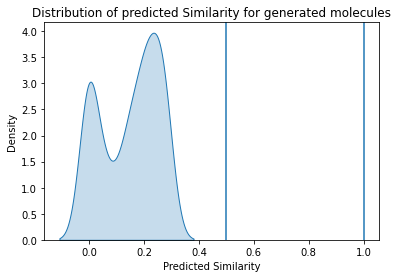

Sample trajectories:
C1OOCCOO1
C1OOO1
C1OO1
C1CO1
COOOONO
58 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:22<00:00,  1.11s/it]


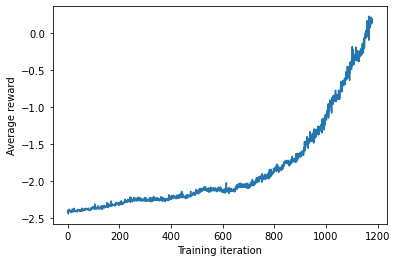

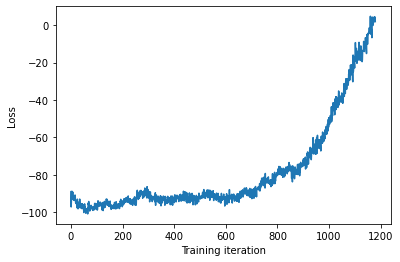

Generating molecules...: 100%|████████████████| 200/200 [00:08<00:00, 24.23it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


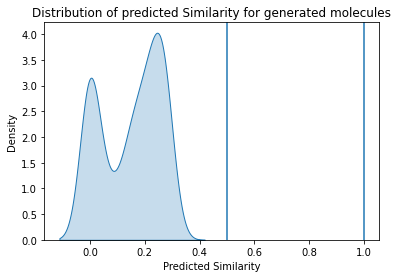

Sample trajectories:
CCOOOO
C1CO1
N1CO1
C=1OOON=1
COOO
59 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:24<00:00,  1.23s/it]


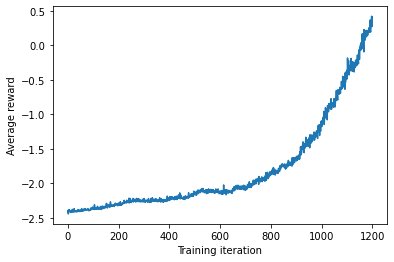

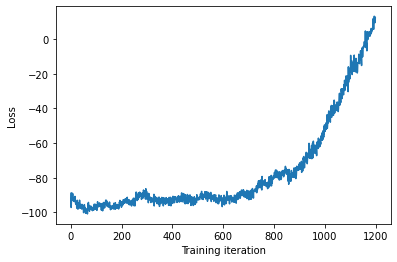

Generating molecules...: 100%|████████████████| 200/200 [00:07<00:00, 25.13it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


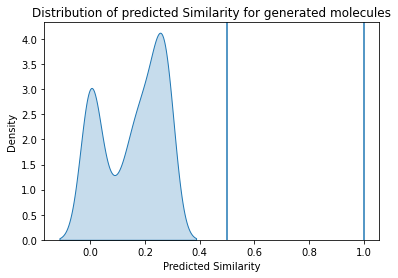

Sample trajectories:
C1OO1
C=COO
[N+1]COOOF
COOOO
[N-1](O)O
60 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:26<00:00,  1.33s/it]


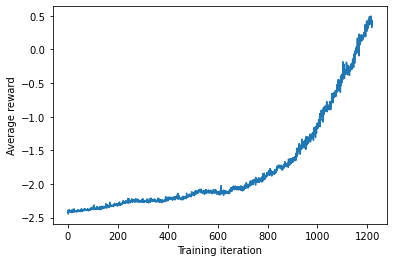

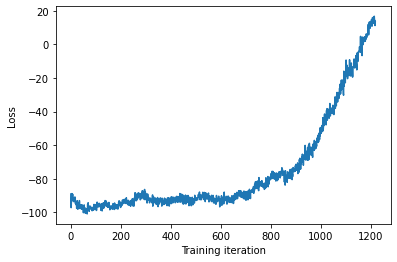

Generating molecules...: 100%|████████████████| 200/200 [00:08<00:00, 23.83it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


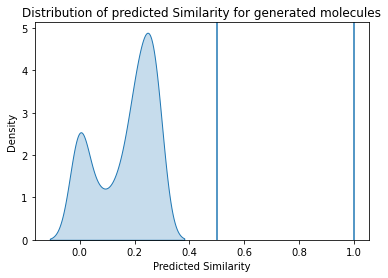

Sample trajectories:
C1COO1
C1OOOO1
C1OOOO1
C1OOO1
C1OCOOOOO1
61 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:24<00:00,  1.25s/it]


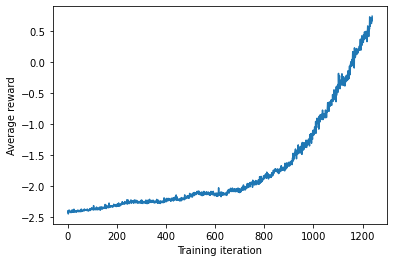

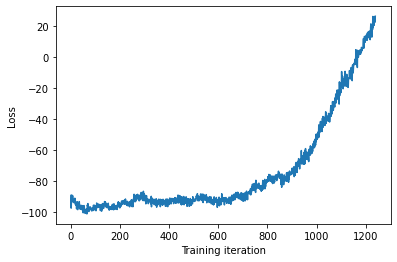

Generating molecules...: 100%|████████████████| 200/200 [00:09<00:00, 21.25it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


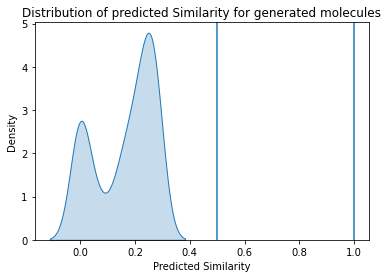

Sample trajectories:
C=O
C1=NOO1
N1(C)OO1
C1COOO1
C1=CNO1
62 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:26<00:00,  1.31s/it]


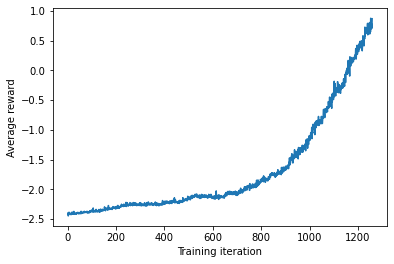

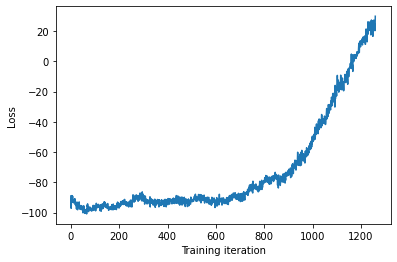

Generating molecules...: 100%|████████████████| 200/200 [00:08<00:00, 22.90it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


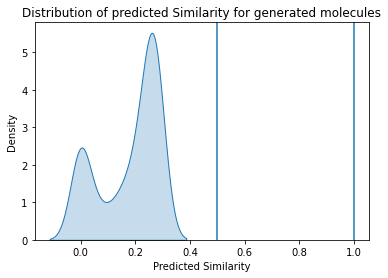

Sample trajectories:
C1OO1
CCOOO
C1OO1
C1COO1
C12=SN=[B-1]1CCOO2
63 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:27<00:00,  1.40s/it]


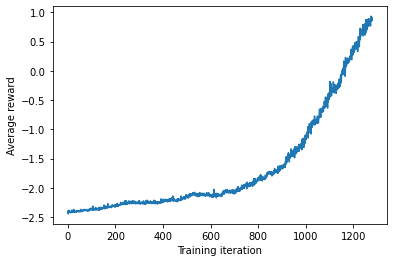

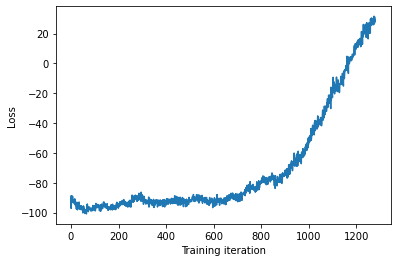

Generating molecules...: 100%|████████████████| 200/200 [00:09<00:00, 20.17it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


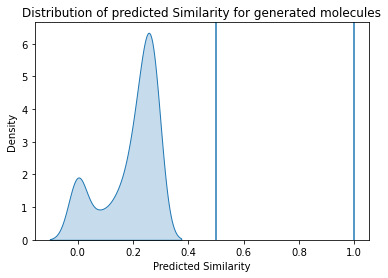

Sample trajectories:
C1OOO1
C1OOOOO1
C1OO1
C#1OOOS#1
C1#CO1
64 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:30<00:00,  1.50s/it]


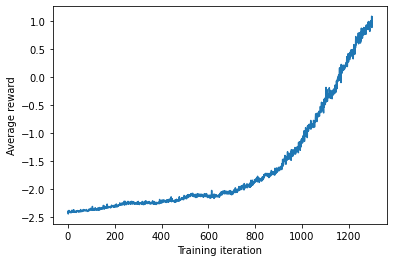

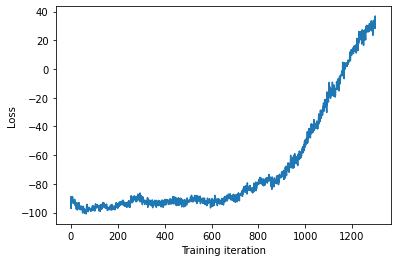

Generating molecules...: 100%|████████████████| 200/200 [00:11<00:00, 17.25it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


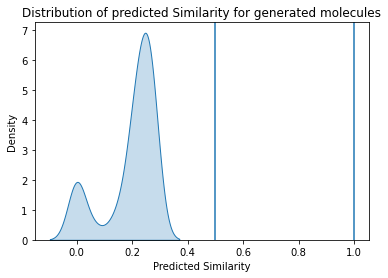

Sample trajectories:
C1OCOCOOOO1
C1COOO1
[N-1]COOO
CCOOO
C=O
65 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:33<00:00,  1.67s/it]


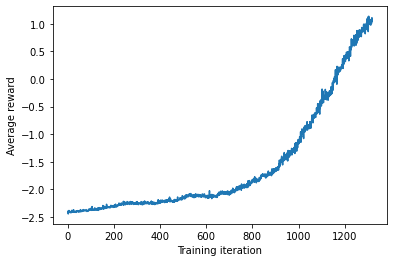

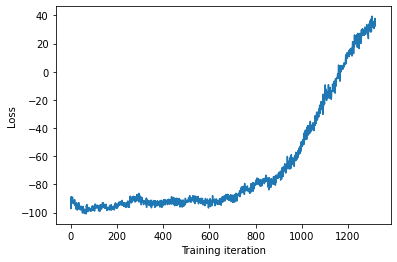

Generating molecules...: 100%|████████████████| 200/200 [00:10<00:00, 19.37it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


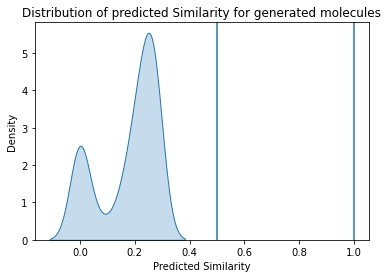

Sample trajectories:
C1OO1
C1OCO1
C1CO1
C=O
C1CO1
66 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:29<00:00,  1.46s/it]


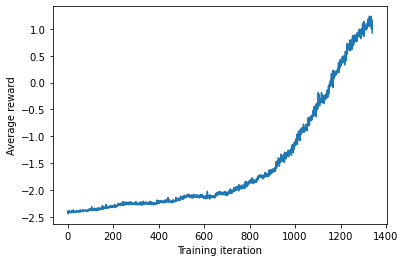

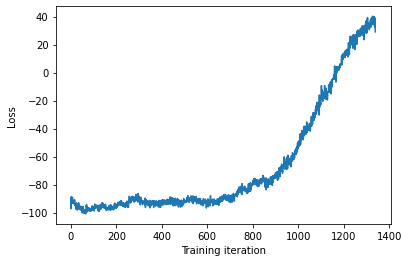

Generating molecules...: 100%|████████████████| 200/200 [00:09<00:00, 21.56it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


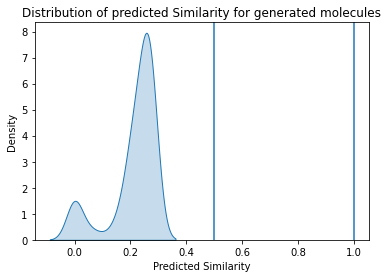

Sample trajectories:
C1OCO1
C1OOOO1
C1OOO1
C1OCOOO1
C1OOO1
67 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:29<00:00,  1.49s/it]


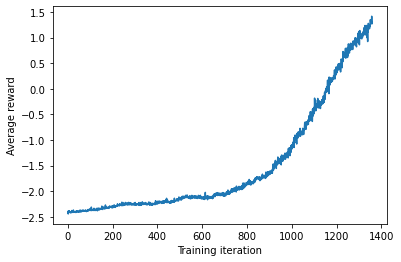

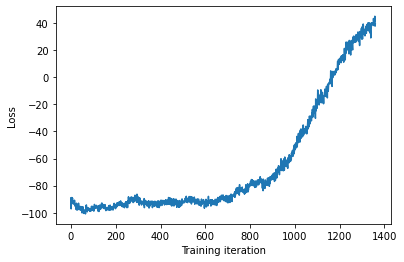

Generating molecules...: 100%|████████████████| 200/200 [00:12<00:00, 16.29it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


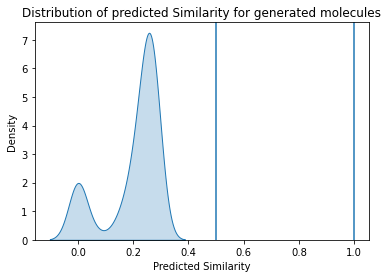

Sample trajectories:
C1OOOO1
C1COOO1
C1OO1
C1OOOO1
C1OOO1
68 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:31<00:00,  1.59s/it]


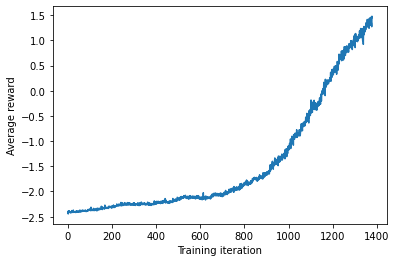

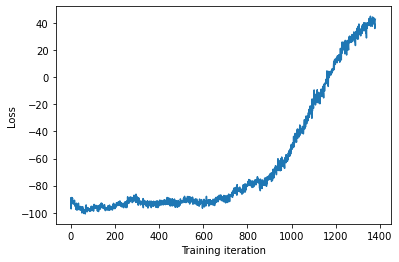

Generating molecules...: 100%|████████████████| 200/200 [00:12<00:00, 15.75it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


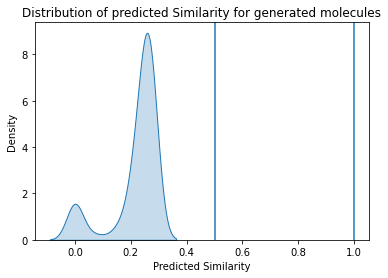

Sample trajectories:
C1OOO1
C1OOOO1
C1OOO1
C=O
C12OOOC1O2
69 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:36<00:00,  1.81s/it]


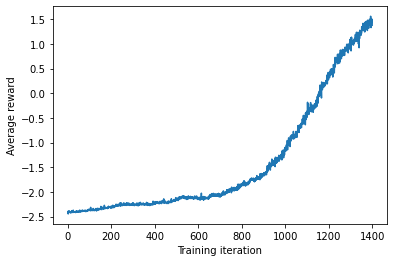

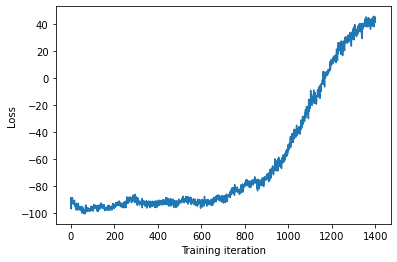

Generating molecules...: 100%|████████████████| 200/200 [00:13<00:00, 14.96it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


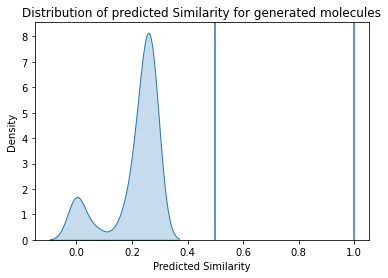

Sample trajectories:
C1OO1
C1=CO1
C1OO1
C1OO1
C1OOO1
70 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:38<00:00,  1.93s/it]


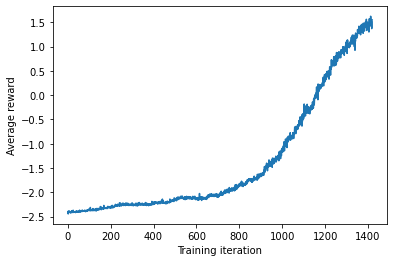

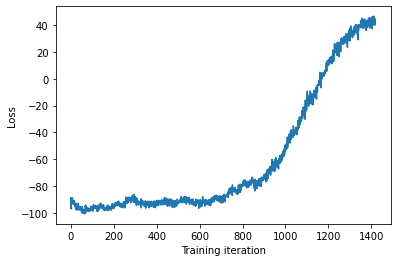

Generating molecules...: 100%|████████████████| 200/200 [00:14<00:00, 13.69it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


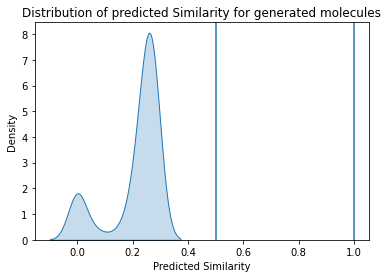

Sample trajectories:
C1OO1
C=O
C1OO1
CCl
C1CCOO1
71 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:32<00:00,  1.64s/it]


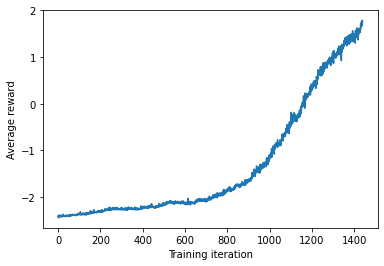

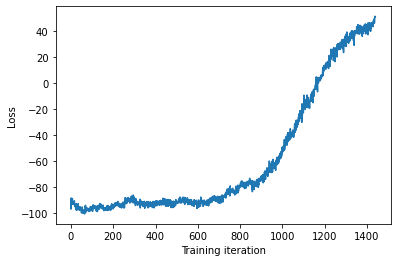

Generating molecules...: 100%|████████████████| 200/200 [00:11<00:00, 17.04it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


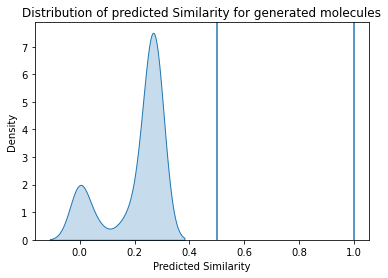

Sample trajectories:
C1OO1
C1CO1
C=O
C1COO1
C1COO1
72 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:31<00:00,  1.60s/it]


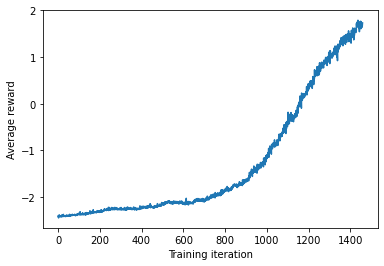

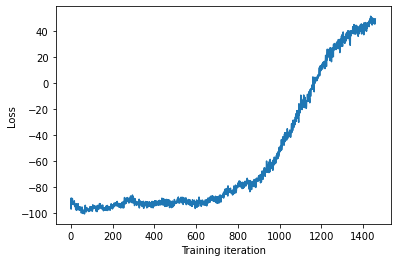

Generating molecules...: 100%|████████████████| 200/200 [00:12<00:00, 16.21it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


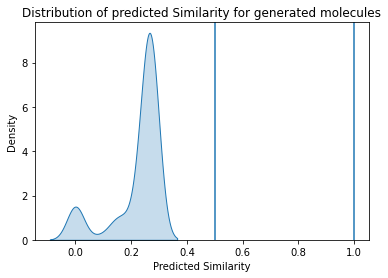

Sample trajectories:
C1OO1
C1OO1
C1COO1
C1OO1
C1ONO1
73 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:38<00:00,  1.91s/it]


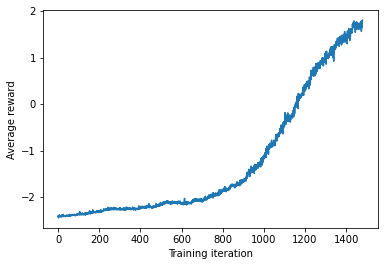

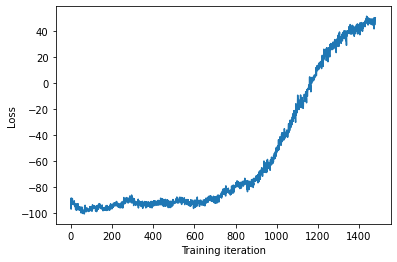

Generating molecules...: 100%|████████████████| 200/200 [00:14<00:00, 14.17it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


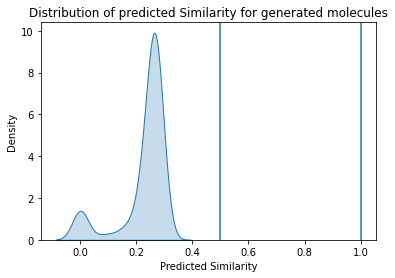

Sample trajectories:
C1OCOO1
C1COOO1
C1COO1
C1OOO1
C1OO1
74 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:37<00:00,  1.86s/it]


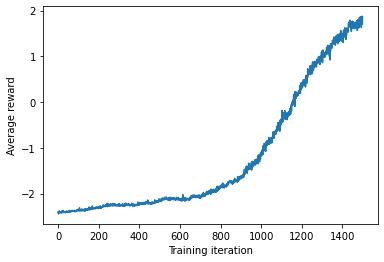

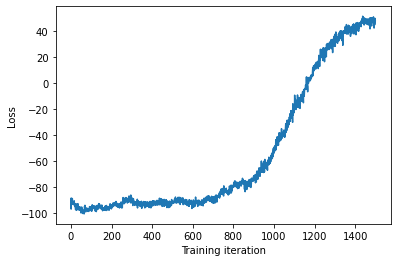

Generating molecules...: 100%|████████████████| 200/200 [00:16<00:00, 12.40it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


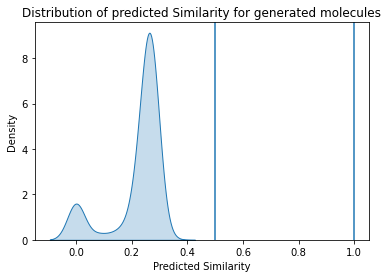

Sample trajectories:
C1OO1
C1OO1
C1O[C+1]O1
C1OO1
C1OOO1
75 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:37<00:00,  1.90s/it]


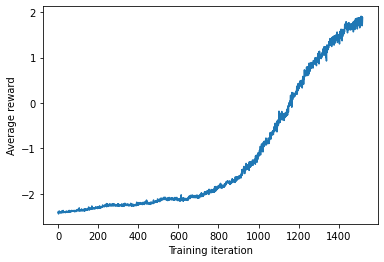

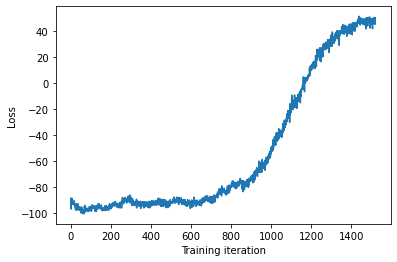

Generating molecules...: 100%|████████████████| 200/200 [00:13<00:00, 15.36it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


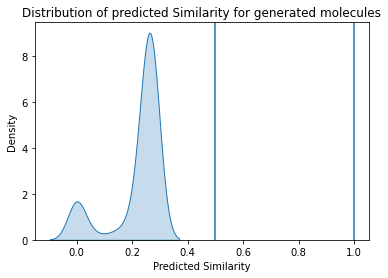

Sample trajectories:
C1OO1
C1OOO1
C1OOO1
C1OOO1
C1OO1
76 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:41<00:00,  2.06s/it]


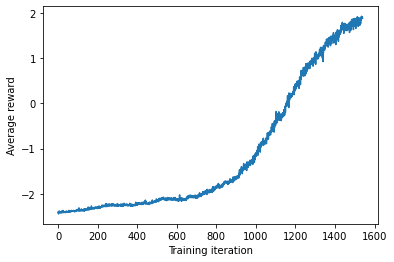

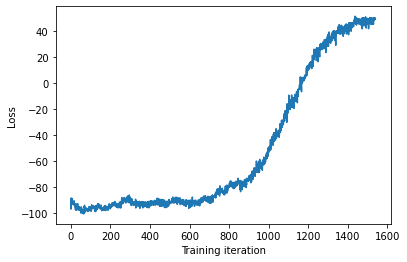

Generating molecules...: 100%|████████████████| 200/200 [00:16<00:00, 12.42it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


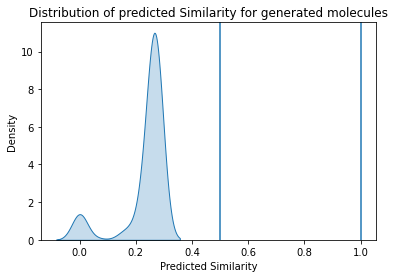

Sample trajectories:
C1COO1
C1OO1
C1OOOO1
C1OO1
C1OO1
77 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:40<00:00,  2.03s/it]


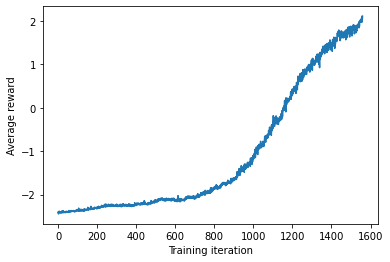

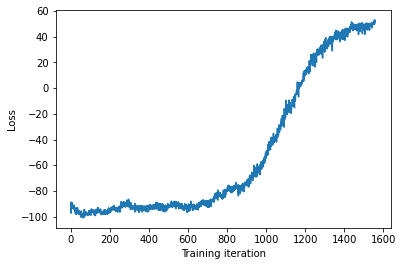

Generating molecules...: 100%|████████████████| 200/200 [00:16<00:00, 11.94it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


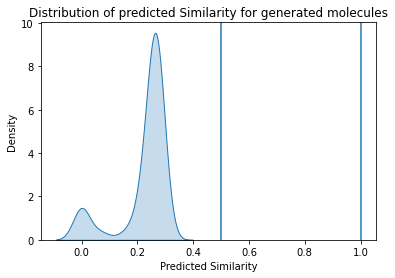

Sample trajectories:
C1OOO1
C1OO1
COOO
C1OOO1
C1OO1
78 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:40<00:00,  2.03s/it]


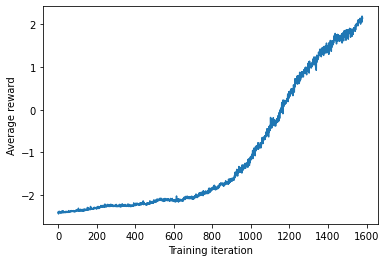

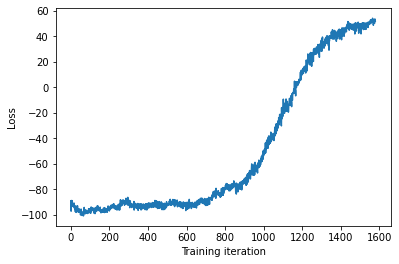

Generating molecules...: 100%|████████████████| 200/200 [00:15<00:00, 12.66it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


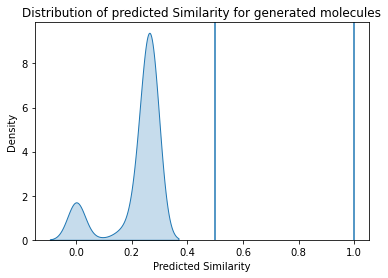

Sample trajectories:
C1COO1
C1OO1
C1OO1
C1OOO1
C1OO1
79 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:43<00:00,  2.16s/it]


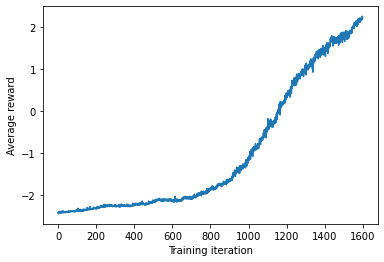

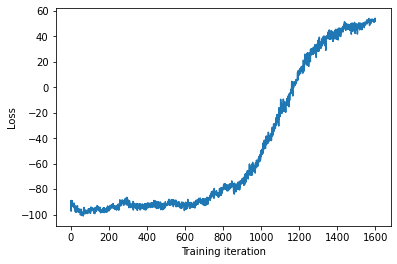

Generating molecules...: 100%|████████████████| 200/200 [00:17<00:00, 11.70it/s]

200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


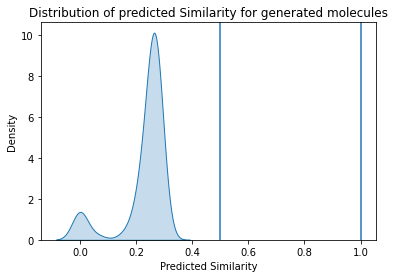

Sample trajectories:
C1OO1
C1COO1
C1COO1
C1OOO1
C1OOO1
80 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:41<00:00,  2.06s/it]


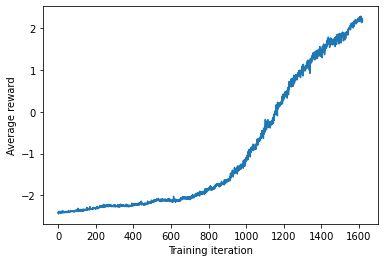

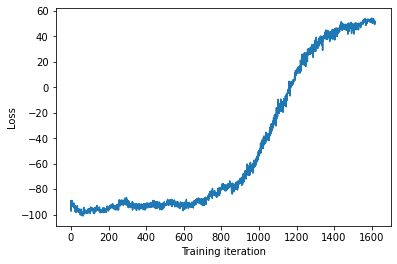

Generating molecules...: 100%|████████████████| 200/200 [00:15<00:00, 12.81it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


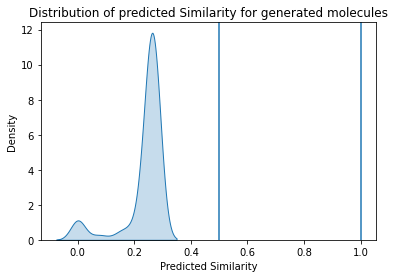

Sample trajectories:
C1OOO1
C1OO1
C1COO1
C1OO1
C1OOO1
81 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:39<00:00,  1.98s/it]


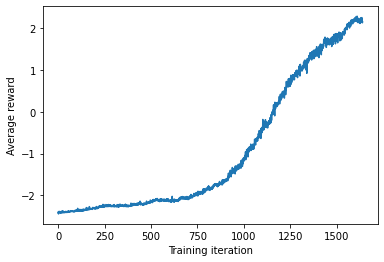

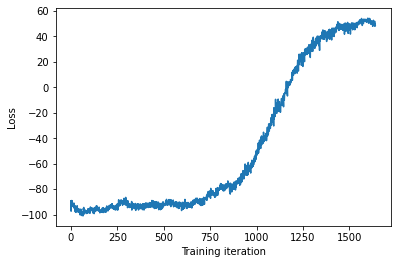

Generating molecules...: 100%|████████████████| 200/200 [00:15<00:00, 12.81it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


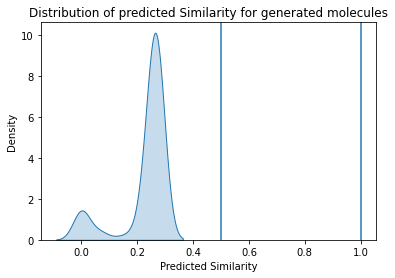

Sample trajectories:
C1OO1
C=O
C1OOO1
C1OOO1

82 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:41<00:00,  2.06s/it]


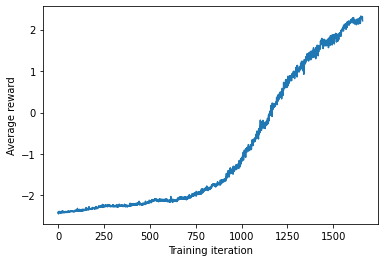

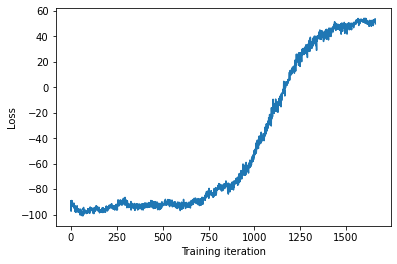

Generating molecules...: 100%|████████████████| 200/200 [00:15<00:00, 12.96it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


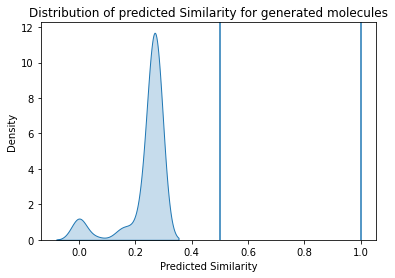

Sample trajectories:
C1OO1
C1OOO1
C1COO1
C1OOO1
C1OO1
83 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:40<00:00,  2.02s/it]


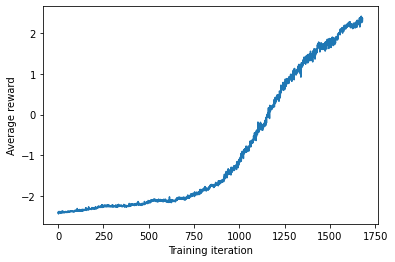

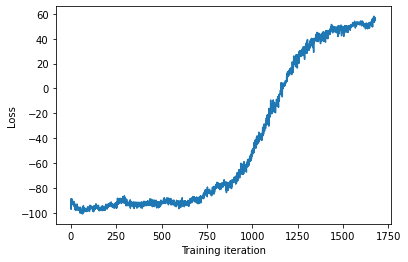

Generating molecules...: 100%|████████████████| 200/200 [00:14<00:00, 13.66it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


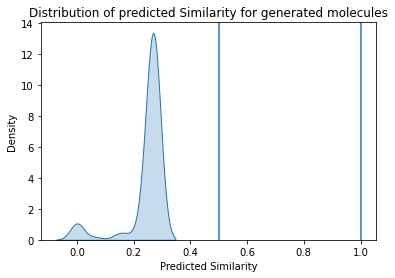

Sample trajectories:
C1OOO1
C1OO1
C1COOON1C=O
C1OO1
C1OO1
84 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:38<00:00,  1.93s/it]


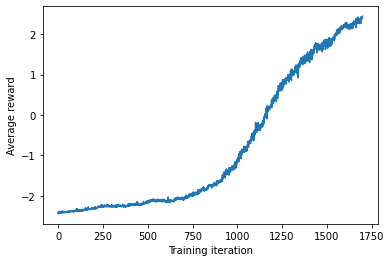

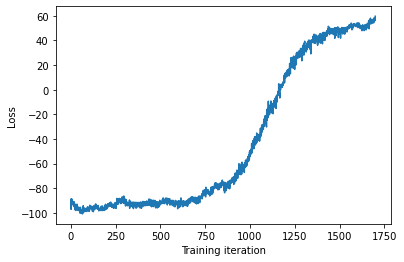

Generating molecules...: 100%|████████████████| 200/200 [00:15<00:00, 13.17it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


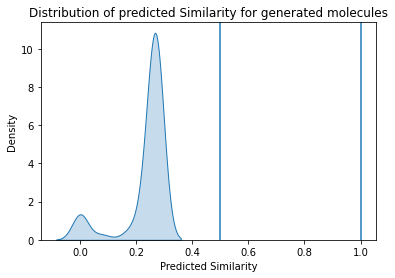

Sample trajectories:
C1OOO1
C1OO1
C1OO1
C1OO1
C1OOO1
85 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:42<00:00,  2.11s/it]


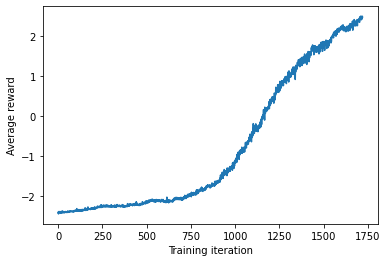

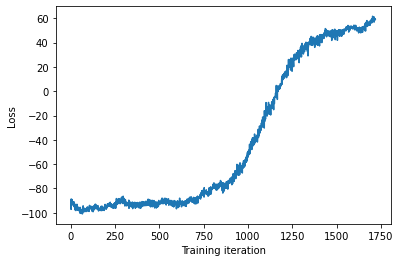

Generating molecules...: 100%|████████████████| 200/200 [00:17<00:00, 11.37it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


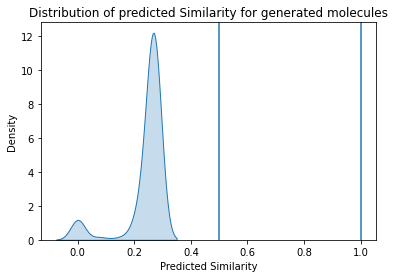

Sample trajectories:
C1OO1
C=O
C1OOO1
C1NOO1
COOO
86 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:40<00:00,  2.03s/it]


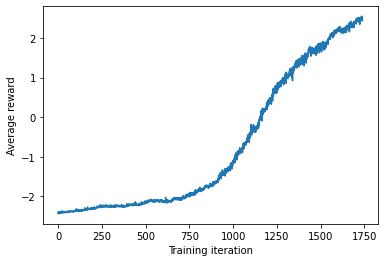

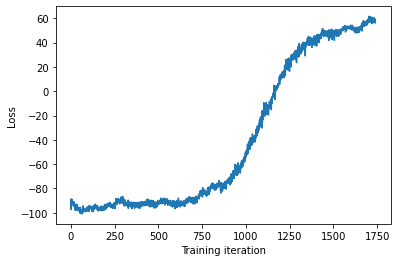

Generating molecules...: 100%|████████████████| 200/200 [00:15<00:00, 12.59it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


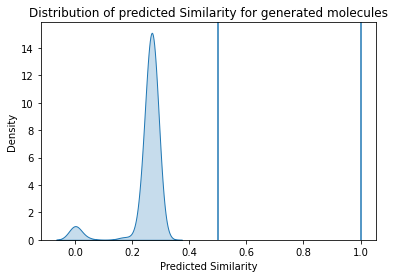

Sample trajectories:
C1OO1
C1OOO1
C1OOO1
C1OO1
C1OO1
87 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:42<00:00,  2.15s/it]


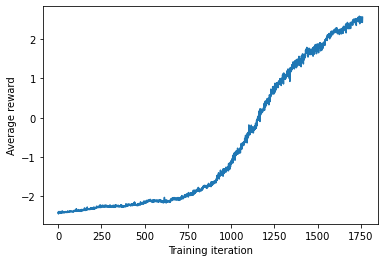

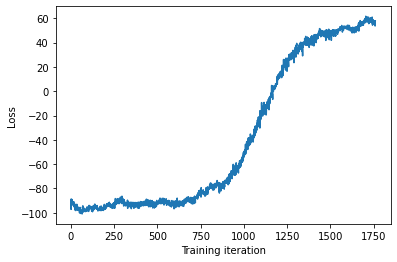

Generating molecules...: 100%|████████████████| 200/200 [00:17<00:00, 11.44it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


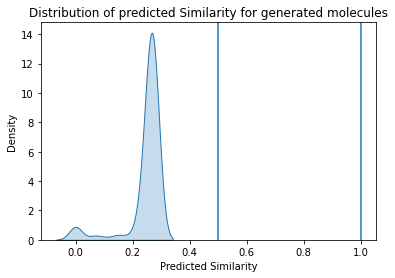

Sample trajectories:
C1OO1
C1OO1
C1OO1
C1COO1
C1OO1
88 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:41<00:00,  2.10s/it]


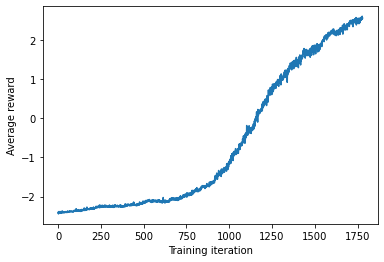

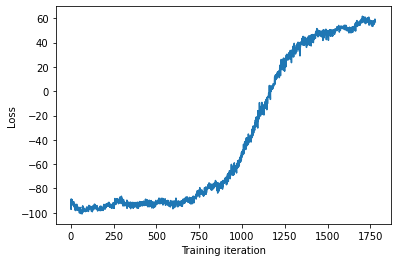

Generating molecules...: 100%|████████████████| 200/200 [00:16<00:00, 12.39it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


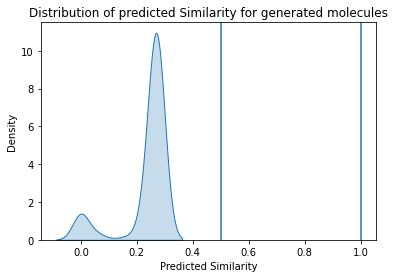

Sample trajectories:
COOO
C1COO1
C1COO1
C1OO1
C1OO1
89 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:42<00:00,  2.12s/it]


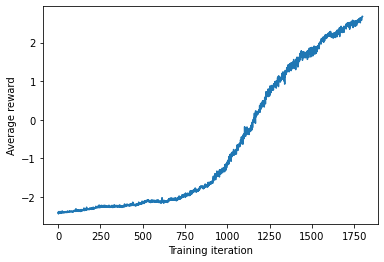

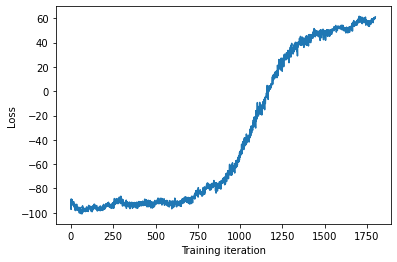

Generating molecules...: 100%|████████████████| 200/200 [00:16<00:00, 12.04it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


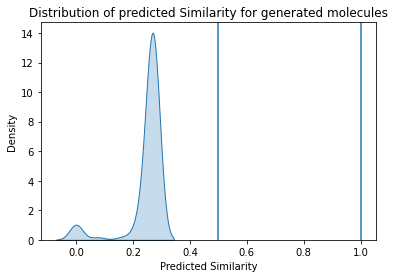

Sample trajectories:
C1OO1
C1OO1
C1OO1
C1OO1
C1OO1
90 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:41<00:00,  2.06s/it]


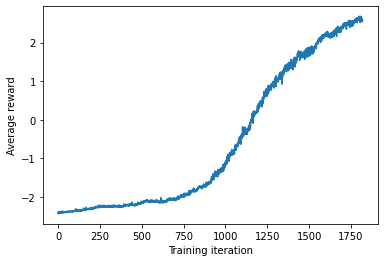

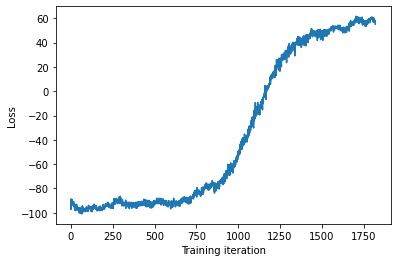

Generating molecules...: 100%|████████████████| 200/200 [00:16<00:00, 12.15it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


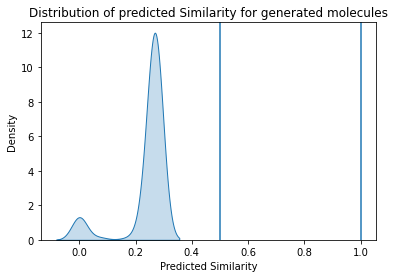

Sample trajectories:
C1OOO1
N=O
C1OOO1
C1OO1
O
91 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:43<00:00,  2.19s/it]


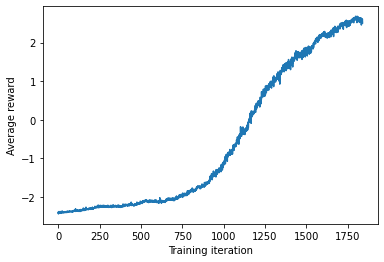

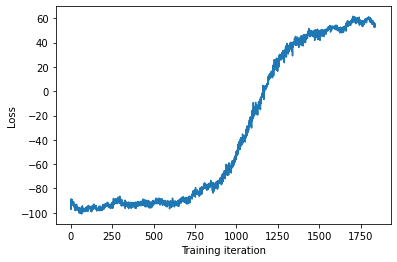

Generating molecules...: 100%|████████████████| 200/200 [00:17<00:00, 11.13it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


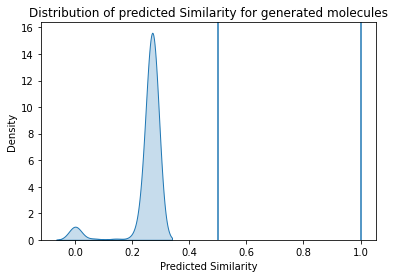

Sample trajectories:
C=O
C1COO1
C1OO1
C1OO1
C1OOO1
92 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:44<00:00,  2.20s/it]


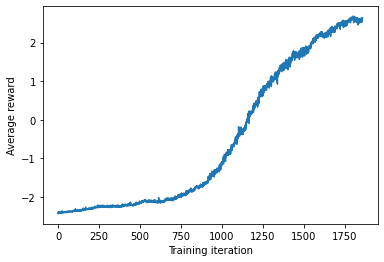

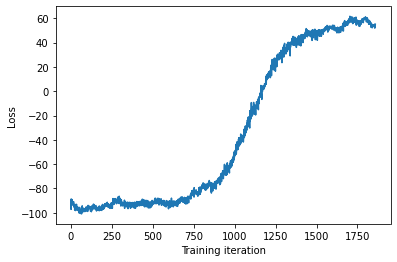

Generating molecules...: 100%|████████████████| 200/200 [00:16<00:00, 11.77it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


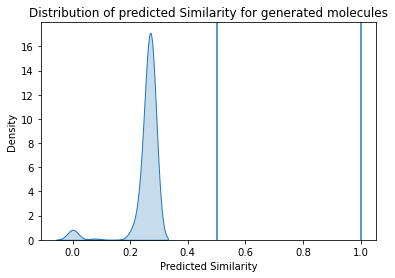

Sample trajectories:
C1OO1
C1OO1
C1OO1
C1OO1
C1OOO1
93 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:43<00:00,  2.17s/it]


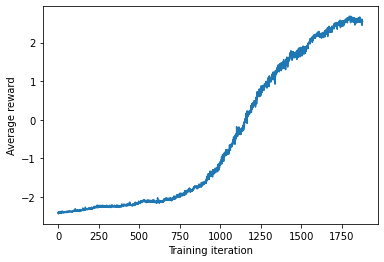

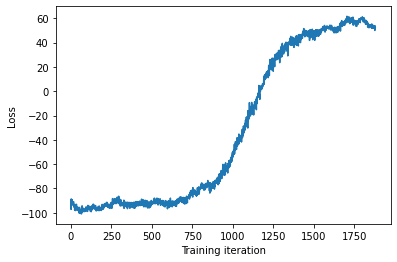

Generating molecules...: 100%|████████████████| 200/200 [00:17<00:00, 11.60it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


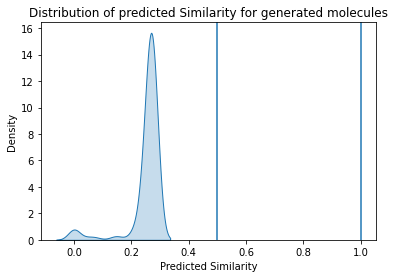

Sample trajectories:
C1OO1
C1OOO1
C1COO1
C1OO1
C1OOO1
94 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:42<00:00,  2.11s/it]


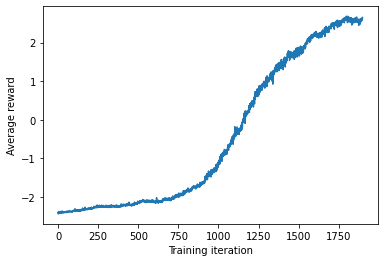

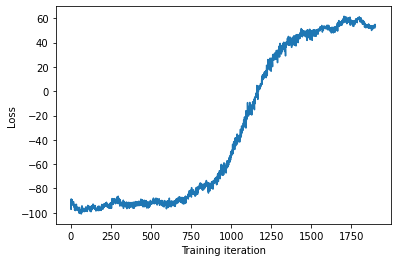

Generating molecules...: 100%|████████████████| 200/200 [00:16<00:00, 11.77it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


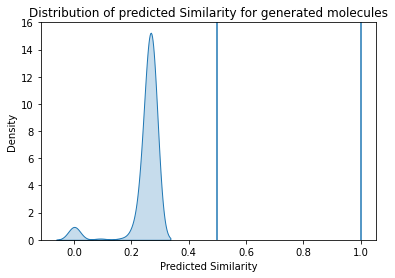

Sample trajectories:
C1OO1
C1OO1
C1OOO1
C1OO1
C1OO1
95 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:42<00:00,  2.13s/it]


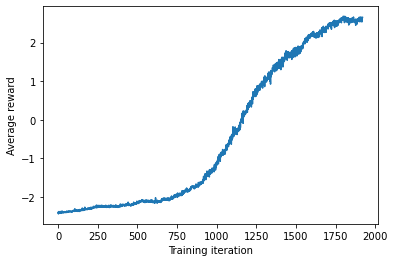

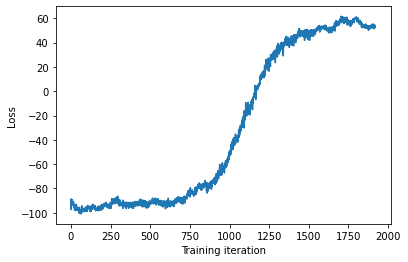

Generating molecules...: 100%|████████████████| 200/200 [00:17<00:00, 11.73it/s]

200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


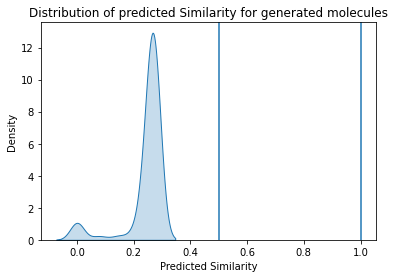

Sample trajectories:
C1OO1
C1OOO1
C1OO1
C1=COO1
O1OO1
96 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:40<00:00,  2.03s/it]


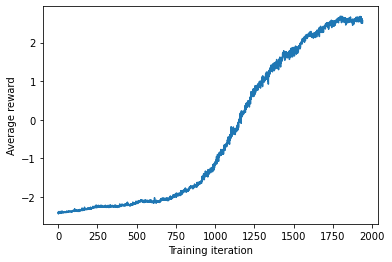

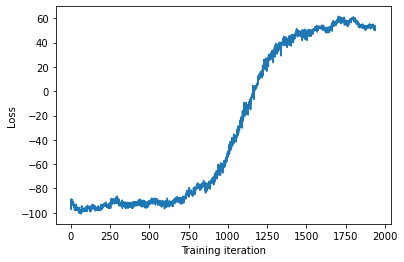

Generating molecules...: 100%|████████████████| 200/200 [00:17<00:00, 11.54it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


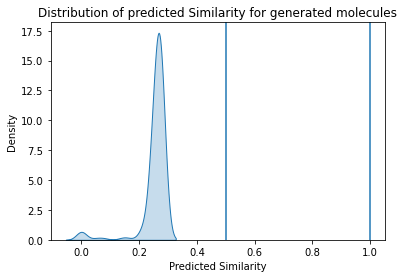

Sample trajectories:
C1OOO1
C1OOO1
C1OOO1
C1OOO1
C1OO1
97 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:41<00:00,  2.07s/it]


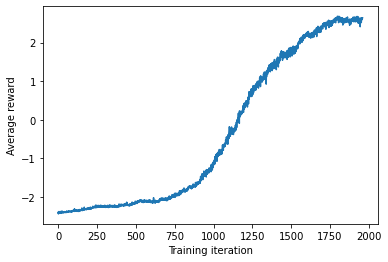

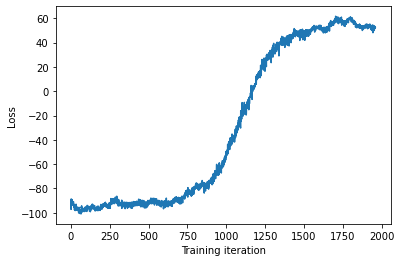

Generating molecules...: 100%|████████████████| 200/200 [00:16<00:00, 11.80it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


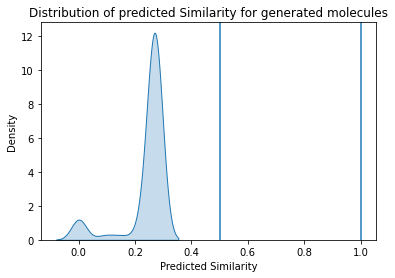

Sample trajectories:
C1OO[P+1]O1
C1OO1
C1OOO1
COOO
C1OO1
98 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:38<00:00,  1.95s/it]


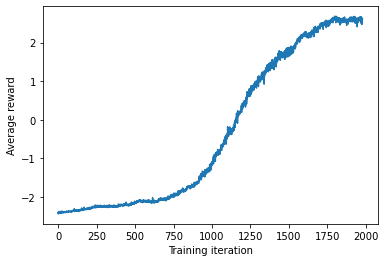

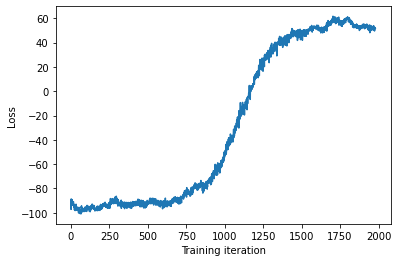

Generating molecules...: 100%|████████████████| 200/200 [00:16<00:00, 12.36it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


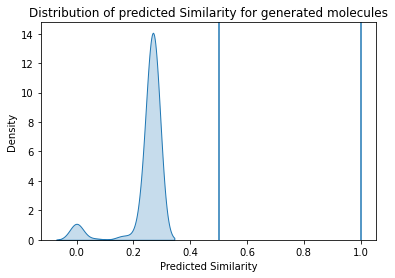

Sample trajectories:
C1OO1
C1OO1
C=O
C1OO1
C1OO1
99 out of 100 complete!


Policy gradient...: 100%|███████████████████████| 20/20 [00:41<00:00,  2.09s/it]


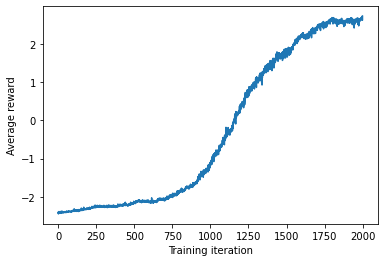

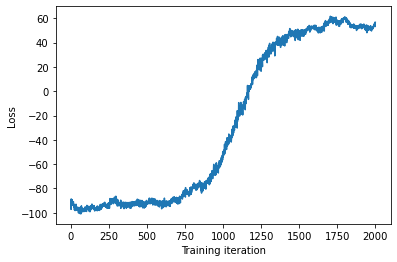

Generating molecules...: 100%|████████████████| 200/200 [00:13<00:00, 14.35it/s]


200
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


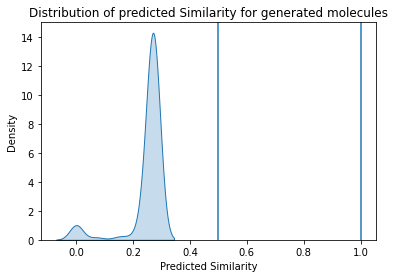

Sample trajectories:
C1OO1
C1OOO1
C1OO1
C1OO1
C1OO1
100 out of 100 complete!


In [60]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_logp.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_logp.generator, 
                                                     my_predictor, drug, 
                                                     n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)
    print(str(i+1) + " out of " + str(n_iterations) + " complete!")

Generating molecules...: 100%|██████████████| 1000/1000 [01:12<00:00, 13.77it/s]


1000
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 1.0


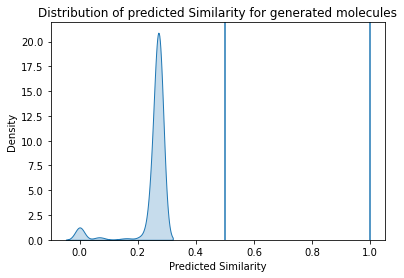

In [61]:
smiles_biased, prediction_biased = estimate_and_update(RL_logp.generator, 
                                                       my_predictor,
                                                       drug,
                                                       n_to_generate=1000)

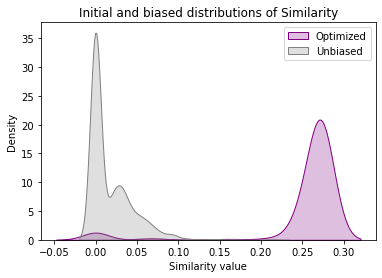

In [62]:
sns.kdeplot(prediction_biased, label='Optimized', shade=True, color='purple')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('Similarity value')
plt.title('Initial and biased distributions of Similarity')
plt.legend()
plt.show()

### Drawing random molecules

Now we will draw some random compounds from the biased library:

In [ ]:
mol, pred, invalid = my_predictor.predictFromSmiles(smiles_biased)

In [ ]:
goodDrugsTuple = []
for i in range(len(mol)):
    if pred[i] > 0.5:
        goodDrugsTuple.append((mol[i],pred[i]))

In [ ]:
import pandas as pd
goodDrugs = pd.DataFrame(goodDrugsTuple,columns = ['Drug','Pred'])

In [ ]:
goodDrugsUniquified = goodDrugs.drop_duplicates()

In [ ]:
goodDrugsUniquified

In [ ]:
print('Uniqueness is ' + "%.2f" % (len(goodDrugsUniquified)/len(goodDrugs)))

In [ ]:
goodBiasedDrugsUnique = goodDrugsUniquified['Drug'].tolist()
goodBiasedPredsUnique = goodDrugsUniquified['Pred'].tolist()

In [ ]:
from rdkit.Chem import Draw

In [ ]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

In [ ]:
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in goodBiasedDrugsUnique] #could use just smiles_biased 

In [ ]:
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]

In [ ]:
sanitized_gen_mols

In [ ]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['Similarity = ' + str(goodBiasedPredsUnique[i]) for i in ind] #or prediction_biased if all good and bad

In [ ]:
Draw.MolsToGridImage(mols_to_draw, molsPerRow=4, 
                     subImgSize=(200,200), legends=legends)